<div style="text-align:center"> 
        <strong style="font-size:30px;"> <br> Machine Learning : <br>  Classification de vêtements </strong> 
    <br><br>
    <strong style="font-size:20px;">Joël Hamilcaro & Jie Tu
    </strong> 
</div>


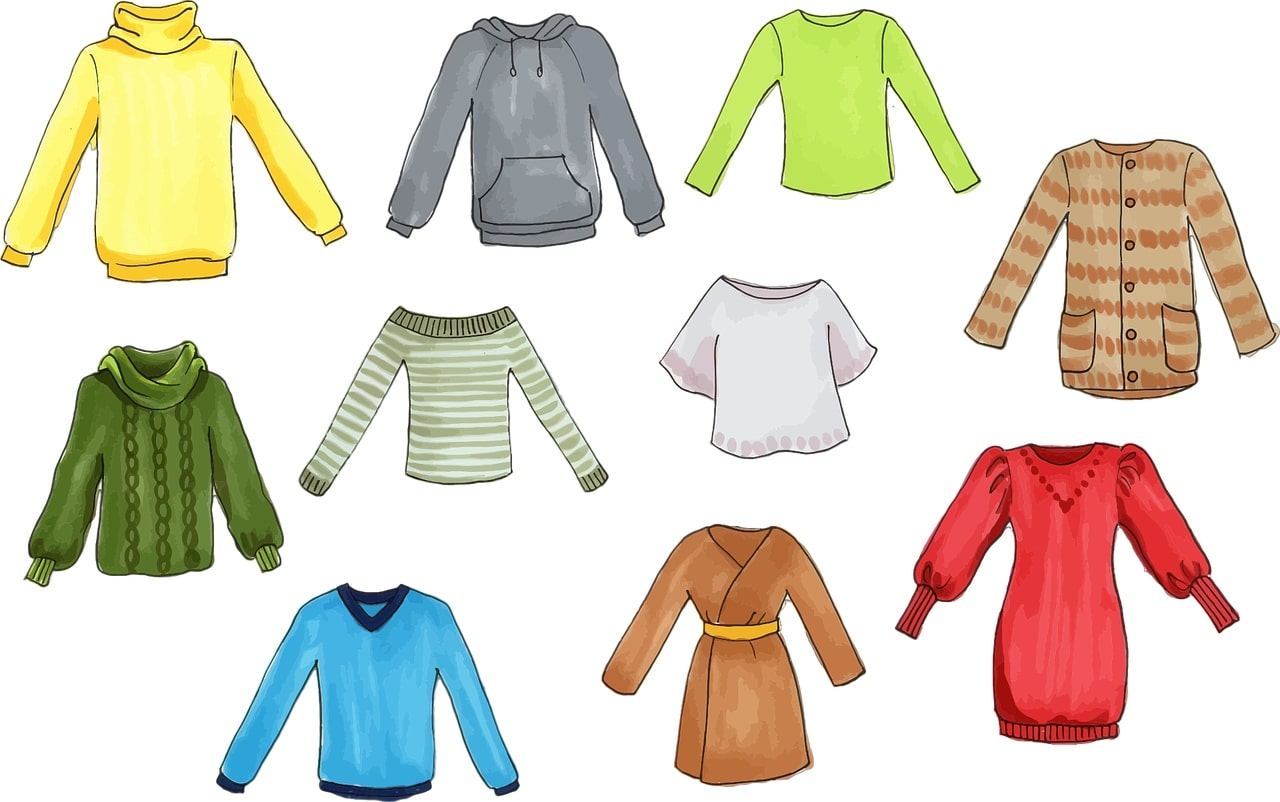

<div style="text-align:right;font-style:italic">
    Dessins de vêtements (Source : Pixabay free Image)
</div>

# Introduction

Notre objectif est de programmer un réseau de neurones artificiel qui, à partir d'une image de vêtement, est capable de prédire à quelle classe appartient ce vêtement (t-shirt, pantalon, robe, ...).

Pour cela, nous allons utiliser le jeu de donnée `fashion_mnist`, de l'API `tensorflow.keras`. Ici, les vêtements appartiennent à l'une des dix classes suivantes : 

- 👕 T-shirt/Haut 
- 👖 Pantalon 
- 🧥 Pull-over
- 👗 Robe
- 🥼 Manteau
- 👡 Sandale
- 👚 Chemise
- 👟 Sneaker
- 👜 Sac
- 🥾 Botte

**Formalisation du problème :**

Pour chaque individu 𝑖 de notre jeu de donnée, on a une image $x_i$ et un label $y_i \in \{0,1,2,3,4,5,6,7,8,9\}$ correspondant à une classe de vêtement.

Problème : Étant donné une image $x$ on veut prédire le label $y$.

Il s'agit d'un problème de classification multi-classes.

# Paramétrage de l'environnement 

Dans un premier temps, nous devons configurer ce notebook dans le cas où il serait exécuté dans `google colab`. Cela nous permettra d'avoir accès à certaines bibliothèques (non incluses par défaut), et d'avoir accès à un espace de stockage (pour sauvegarder et charger nos futurs modèles).

In [1]:
# Mount drive storage in Google Colab
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install keras_tuner

# Importation des librairies nécessaires

On importe ici toutes les librairies qui nous seront nécessaires par la suite. De plus, on définit les constantes de notre programme.

In [2]:
# Files Read/Write
import pickle as pkl
import os
from PIL import Image

# Math/Calculation
import numpy as np
from numpy.random import seed
import random

# Visualizations
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as PathEffects

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

# Deep Learning 
import tensorflow as tf
from tensorflow.keras import utils, losses, optimizers, backend as K
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, \
    Flatten, Conv2D, MaxPooling2D, AveragePooling2D, Activation
from tensorflow.image \
    import resize_with_crop_or_pad, pad_to_bounding_box, \
            adjust_contrast, adjust_gamma
from keras.utils.vis_utils import plot_model
import keras_tuner as kt

# Constants
COLORS_3 = ["#18CAE6","#53117F","#366EB3"]
COLORS_5 = ['#00429d', '#5d92bb', '#90ee90', '#d66f64', '#93003a']
FILE_PATH = "drive/MyDrive/DM2_fashion_mnist/"
IMG_PATH = FILE_PATH+"img/"
NB_CLASSES = 10

# Chargement des données

On charge maintenant le jeu de données `fashion_mnist`, de l'API `tensorflow.keras`. Il est constitué de données pour d'entrainement (pour entrainer nos modèles), et de données test (pour l'évaluation des modèles).

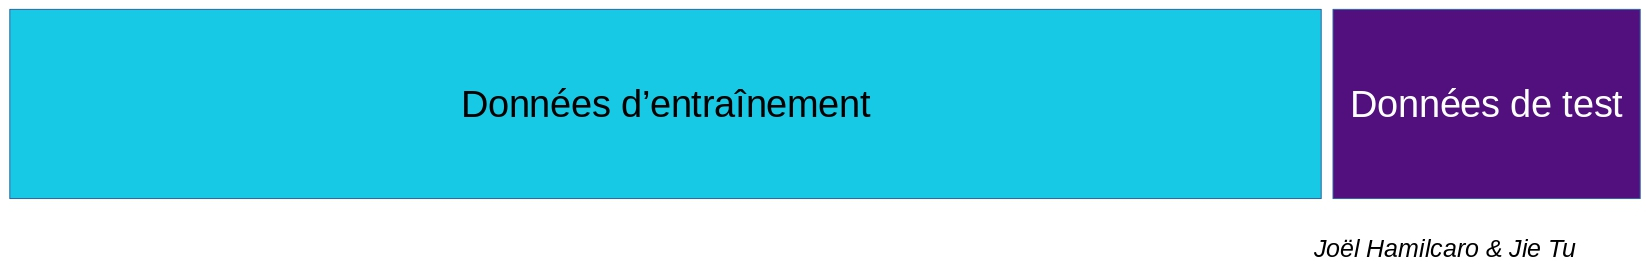

In [3]:
(train_images, train_labels) , (test_images, test_labels) = \
    fashion_mnist.load_data()

# Exploration des données

## Aperçu rapide des données

Dans notre jeu de données, les labels prennent des valeurs dans l'ensemble $\{0,1,2,3,4,5,6,7,8,9\}$. La correspondance entre la valeur numérique du label est le nom d'une classe de vêtements est définie dans le tableau suivant :

| Label number | Label name  |
|--------------|-------------|
| 0	           | T-shirt/top |
| 1	           | Trouser     |
| 2	           | Pullover    |
| 3	           | Dress       |
| 4	           | Coat        |
| 5	           | Sandal      |
| 6	           | Shirt       |
| 7	           | Sneaker     |
| 8	           | Bag         |
| 9	           | Ankle boot  |

On va tout d'abord créé un dictionnaire qui associe la valeur numérique du label à la classe de vêtements. Ce dictionnaire nous servira à de nombreuses reprises pour les visualisations.

In [4]:
# label_dict[i] -> Name of i-th label
label_dict = {
    0 : "T-shirt",
    1 : "Trouser",
    2 : "Pull",
    3 : "Dress",
    4 : "Coat",
    5 : "Sandal",
    6 : "Shirt",
    7 : "Sneaker",
    8 : "Bag",
    9 : "Boot"
}

Dans un second temps, on observe un exemple d'image $x_i$ parmi les données d'entrainement. Une image est encodée dans une matrice à coefficient dans $\{0,...,255\}$. Chaque coefficient représente l'intensité de gris d'un pixel.

In [5]:
def print_title(title) :
    """
    
    Display the string in a box (in order to display a headline)
    
    Parameters
    ----------
    title : the string to print
    
    """
    border = '+'+75*'-'+'+'
    print('\n'+border)
    print('¦'+(" "+title+" ").center(75, '~')+'¦')
    print(border+'\n')
    return 


def print_image_to_matrix(i,images) : 
    """
    
    Print the image in a matrix
    
    Parameters
    ----------
    i : 
        index of the image to print
    images : 
        numpy.ndarray of images 
        (same format as train_images from fashion_mnist)
    
    """
    res = images[i].reshape(images.shape[1], images.shape[2])
    res = np.round(res,1)
    res = np.array2string(res, max_line_width=200)
    print(res)
    return 

def img_to_plt(i, images, cmap='gray_r') :
    """
    
    Returns a plot of the image
    
    Parameters
    ----------
    i : 
        index of the image to print
    images : 
        numpy.ndarray of images 
        (same format as train_images from fashion_mnist)
    cmap : 
        color map (default : gray_r)
        
    Returns
    ----------
    matplotlib.pyplot
    
    """
    plt.imshow(images[i].reshape(28, 28), cmap=cmap)
    return plt


+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~~~~ Encodage des images ~~~~~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

Type de l'image (matrice) : <class 'numpy.ndarray'>
Type des pixels (coefficients de la matrice) : uint8

+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~ Exemple d'encodage d'une image ~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

[[  0   0   0   0   0   1   0   0   0   0  41 188 103  54  48  43  87 168 133  16   0   0   0   0   0   0   0   0]
 [  0   0   0   1   0   0   0  49 136 219 216 228 236 255 255 255 255 217 215 254 231 160  45   0   0   0   0   0]
 [  0   0   0   0   0  14 176 222 224 212 203 198 196 200 215 204 202 201 201 201 209 218 224 164   0   0   0   0]
 [  0   0   0   0   0 188 219 200 198 202 198 199 199 201 196 198 198 200 200 

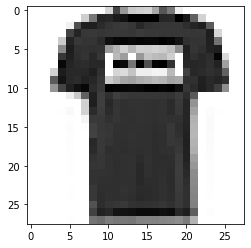

In [6]:
print_title("Encodage des images")
print("Type de l'image (matrice) :",type(train_images))
print("Type des pixels (coefficients de la matrice) :", train_images.dtype)

(print_title("Exemple d'encodage d'une image"))
print_image_to_matrix(1,train_images)  

(print_title("Affichage de l'image correspondante"))
img_to_plt(1,train_images).show()

On peut voir que nous avons 60000 images dans notre jeu d'entraînement. Elles sont encodées dans des matrices de taille $28 \times 28$ :

In [7]:
print_title("Forme des données d'entraînement")
print(train_images.shape)


+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~ Forme des données d'entraînement ~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

(60000, 28, 28)


<hr> On peut observer un échantillon des données d'entraînement.

In [8]:
def plt_sample(n_row, n_col, images, labels, 
                cmap='gray_r', random_state=None , head_0_tail_1=-1 ) :
    """
    
    Display several images and their labels
    
    Parameters
    ----------
    n_row : 
        number of images in a column (number of rows)
    n_col : 
        number of images in a row (number of columns)
        
    images : 
        numpy.ndarray of images 
        (same format as train_images from fashion_mnist)
    
    labels : 
        numpy.ndarray of labels corresponding to the images
        (same format as train_labels from fashion_mnist)
    
    cmap : 
        color map (default : gray_r)
     
    random_state :
        if not None, fix the seed for reproductibility
        
    head_0_tail_1 :
        0 : display the first images (head) of the ndarray
        1 : display the last images (tail) of the ndarray
        other value : display random images of the ndarray
        
    Returns
    ----------
    matplotlib.pyplot
    """ 
    if random_state is not None : seed(random_state)
    plt.figure(figsize=(10, 5))
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i+1)
        if head_0_tail_1 == 0 : idx = i
        elif head_0_tail_1 == 1 : idx = len(images)-i-1
        else : idx = np.random.randint(0,len(images))
        plt.imshow(images[idx].reshape(28, 28), cmap=cmap)
        txt = plt.text(0, 40, 
                       f'  {label_dict[labels[idx]]}'.upper(),
                       c=COLORS_3[0],
                       size="large", 
                       weight="heavy")
        plt.subplots_adjust(left=None, bottom=None, 
                            right=None, top=None, 
                            wspace=None, hspace=None)
        txt.set_path_effects([PathEffects.withStroke(linewidth=4, 
                                                     foreground='black')])
        plt.axis("off")
    plt.tight_layout()
    return plt


+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~ Aperçu d'un échantillon des données ~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+



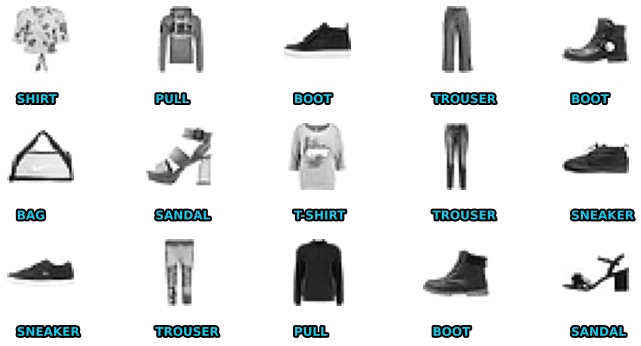

In [9]:
print_title("Aperçu d'un échantillon des données")
plt_sample(n_row=3, n_col=5,
           images=train_images,
           labels=train_labels,
           random_state=12,
           head_0_tail_1=-1).show()

## Distribution des données

On va désormais étudier la distribution des données.

On calcule, pour chaque label, sa proportion dans le jeux d'entraînement et le jeu de test.

In [10]:
def sty(df,test) :
    """
    
    Adds colors to the dataframe 
    (the colors depends of the parameter named "test")
    
    Parameters
    ----------
    df : 
        A Panda dataframe
    test : 
        A boolean value (determines the color)
        
    Returns
    ----------
    pandas.io.formats.style.Styler
    
    """
    return df.style.set_properties(**{
        'background-color': COLORS_3[test],
        'color': ('white' if test else 'black') })


def df_labels_distribution(images, labels) :
    """
    
    Create a dataframe with distributions of labels
    
    Parameters
    ----------
    images : 
        numpy.ndarray of images 
        (same format as train_images from fashion_mnist)
    
    labels : 
        numpy.ndarray of labels corresponding to the images
        (same format as train_labels from fashion_mnist)
        
    Returns
    ----------
    pandas.core.frame.DataFrame
    
    """
    df = pd.DataFrame()            
    df['Label'] = labels
    df = df.groupby(['Label']).size().reset_index(name='Nombre')
    df['Proportion'] = df.Nombre/df.Nombre.sum()
    df['Nom du label'] = list(map(lambda x : label_dict[x] , df.Label))
    
    return df

print_title("Distribution des labels dans le jeu d'entrainement")
df_train_prop = df_labels_distribution(train_images,train_labels)
display( sty(df_train_prop, test=False) )

print_title("Distribution des labels dans le jeu de test")
df_test_prop = df_labels_distribution(test_images,test_labels)
display( sty(df_test_prop, test=True) )


+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~ Distribution des labels dans le jeu d'entrainement ~~~~~~~~~~~¦
+---------------------------------------------------------------------------+



,Label,Nombre,Proportion,Nom du label
0,0,6000,0.100000,T-shirt
1,1,6000,0.100000,Trouser
2,2,6000,0.100000,Pull
3,3,6000,0.100000,Dress
4,4,6000,0.100000,Coat
5,5,6000,0.100000,Sandal
6,6,6000,0.100000,Shirt
7,7,6000,0.100000,Sneaker
8,8,6000,0.100000,Bag
9,9,6000,0.100000,Boot



+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~ Distribution des labels dans le jeu de test ~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+



,Label,Nombre,Proportion,Nom du label
0,0,1000,0.100000,T-shirt
1,1,1000,0.100000,Trouser
2,2,1000,0.100000,Pull
3,3,1000,0.100000,Dress
4,4,1000,0.100000,Coat
5,5,1000,0.100000,Sandal
6,6,1000,0.100000,Shirt
7,7,1000,0.100000,Sneaker
8,8,1000,0.100000,Bag
9,9,1000,0.100000,Boot


In [11]:
def plt_distribution(df_train,df_test,valid=False) :
    """
    
    Create a bar plot of distributions of train and test labels
    
    Parameters
    ----------
    df_train : 
        panda dataframe of distribution with a column named "Proportion"
        and a columns named "Nom du label"
    df_test : 
        panda dataframe of distribution with a column named "Proportion"
        and a columns named "Nom du label"
    valid :
        if True, "test" is replaced by "valid"
    Returns
    ----------
    matplotlib.pyplot
    
    """
    if valid : 
        color = COLORS_3[2]
    else :
        color = COLORS_3[1]
    colors = [COLORS_3[0],color]
    df = pd.DataFrame(np.c_[df_train.Proportion,df_test.Proportion], 
                      index=df_train["Nom du label"])
    df.plot.bar(figsize=(15,5),color=colors)
    plt.legend(["Train","Valid" if valid else "Test"],
               title="Données", loc=4, shadow=True)
    plt.ylabel("Proportion")
    plt.title("Comparaison des distributions")
    return plt

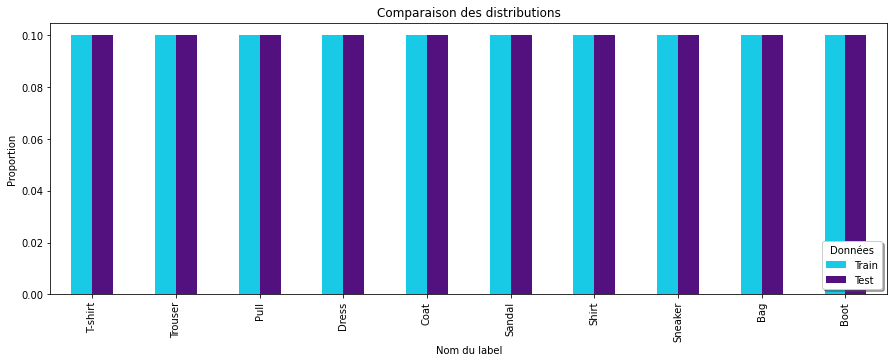

In [12]:
plt_distribution(df_train_prop,df_test_prop).show()

<hr><div class='alert alert-info' role='alert'><p><b>
Les labels sont distribués de manière parfaitement uniforme, à la fois dans le jeu d'entraînement et dans le jeu de test.  
</b></p></div> 

# Préparation des données

On va maintenant préparer nos données avant qu'elles ne soient utilisées pour l'entraînement de notre réseau de neurones artificiels.

## Valeurs manquantes

Tout d'abord, on observe si les données présentent des valeurs manquantes. Si c'est le cas, il faudra les traiter. Pour vérifier s'il y a des valeurs manquantes, on va calculer une valeur booléenne (qui vaudra `True` s'il y a au moins une valeur manquante). On affiche ci-dessous les résultats obtenus.

In [13]:
def print_none(tab) : 
    """
    
    Print a text that describes if there are any missing values in tab
    
    Parameters
    ----------
    tab : 
        the array to check
    
    """
    if (train_labels == None).any() :
        print("Il y a des valeurs manquantes.")
    else : 
        print("Il n'y a aucune valeur manquante.")
    return

In [14]:
print_title("Images du jeu d'entraînement :")
print_none( train_images )
print_title("Labels du jeu d'entraînement :")
print_none( train_labels )
print_title("Labels du jeu de test :")
print_none( test_labels )
print_title("Images du jeu de test :")
print_none( test_images )


+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~ Images du jeu d'entraînement : ~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

Il n'y a aucune valeur manquante.

+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~ Labels du jeu d'entraînement : ~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

Il n'y a aucune valeur manquante.

+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~~ Labels du jeu de test : ~~~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

Il n'y a aucune valeur manquante.

+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~~ Images du jeu de test : ~~~~~~~~~~~~~~~~~~~~~~~~~¦
+--------------------------------

<hr><div class='alert alert-info' role='alert'><p><b>Il n'y a aucune valeur manquante dans toutes nos données.</b></p></div>

## Encodage One-Hot des labels

On va maintenant s'interesser au typage des labels.

In [15]:
print_title("Typage des labels :")
print(train_labels[0].dtype)


+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~~~~ Typage des labels : ~~~~~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

uint8


On peut voir que les labels sont représentés par des entiers `unint8`. On va les convertir en variable catégorielles afin de se débarrasser de potentiels bruits lors de l'apprentissage (e.g. relation d'ordre des entiers). Pour cela, on va réaliser un encodage One-Hot.

**Encodage One-Hot :**

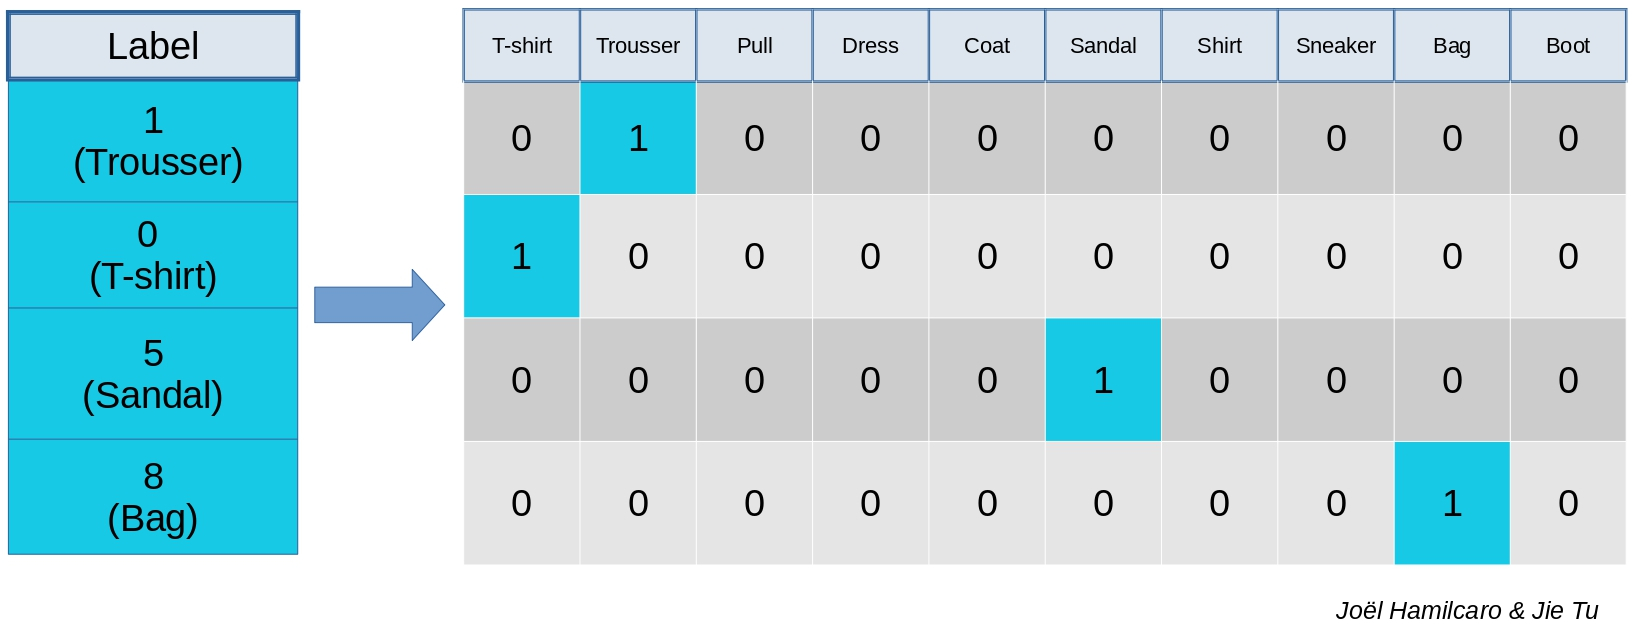

In [16]:
def sty_max(df,test=False, axis=1) :
    """
    
    Adds colors to the maximum box of each row of the dataframe 
    (the colors depends of the parameter named "test")
    
    Parameters
    ----------
    df : 
        A Panda dataframe
    test : 
        A boolean value (determines the color)
        
    Returns
    ----------
    pandas.io.formats.style.Styler
    
    """
    return df.style.highlight_max(axis=axis, color=COLORS_3[test])        

def OHE(labels) :
    """
    
    Return a One-Hot encoded array from a array of labels
    
    Parameters
    ----------
    labels : 
        Array of labels
     
    Returns
    ----------
    numpy.ndarray
    
    """
    labels = utils.to_categorical(labels,NB_CLASSES)
    return labels

In [17]:
print_title("Labels avant encodage One-Hot")
display(sty_max(pd.DataFrame(train_labels).head(5)))
print_title("Labels après encodage One-Hot")
display(sty_max(pd.DataFrame(OHE(train_labels)).head(5)))


+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~ Labels avant encodage One-Hot ~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+



,0
0,9
1,0
2,0
3,3
4,0



+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~ Labels après encodage One-Hot ~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+



,0,1,2,3,4,5,6,7,8,9
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
1,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Normalisation des images

On a pu voir dans la section "*Exploration des données*" que les images étaient des matrices (`numpy.ndarray`) à coefficients entre 0 et 255 (`uint8`). Ce type est pertinent pour encoder les intensités de gris. Cependant, nous allons les modifier en type `float32` afin de pouvoir normaliser nos images. Après normalisation, les valeurs des coefficients de la matrice seront comprises entre 0 et 1.

**Normalisation :**

Pour chaque individu $i \in I$, la $k$-ème feature (notée $X_{i,k}$) sera remplacée par la valeur  : 

$$X_{i,k}^{'} = \dfrac{X_{i,k}- \min_{ j \in I }{( X_{j,k} )}  }{ \max_{ j \in I }{( X_{j,k} )} - \min_{ j \in I }{( X_{j,k} )}  }$$

Ici, comme il s'agit de l'intensité de gris de chaque pixel de l'image (représenté par un nombre entier entre 0 et 255). Il s'agit donc de réaliser l'opération : 

$$X_{i,k}^{'} = \dfrac{X_{i,k}- 0}{ 255 - 0 } = \dfrac{X_{i,k}}{ 255 } $$

In [18]:
def normalization(images,X_max=255,X_min=0) :
    """
    
    Return a array of normalized images
    
    Parameters
    ----------
    images : 
        Array of images
    X_max : 
        Maximum value of a pixel (default 255)
    X_min :
        Minimum value of a pixel (default 0)
     
    Returns
    ----------
    numpy.ndarray
    
    """
    images = images.astype('float')
    images = ( images - X_min ) / ( X_max - X_min ) 
    return images


+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~ Image avant normalisation ~~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

[[  0   0   0   0   0   1   0   0   0   0  41 188 103  54  48  43  87 168 133  16   0   0   0   0   0   0   0   0]
 [  0   0   0   1   0   0   0  49 136 219 216 228 236 255 255 255 255 217 215 254 231 160  45   0   0   0   0   0]
 [  0   0   0   0   0  14 176 222 224 212 203 198 196 200 215 204 202 201 201 201 209 218 224 164   0   0   0   0]
 [  0   0   0   0   0 188 219 200 198 202 198 199 199 201 196 198 198 200 200 200 200 201 200 225  41   0   0   0]
 [  0   0   0   0  51 219 199 203 203 212 238 248 250 245 249 246 247 252 248 235 207 203 203 222 140   0   0   0]
 [  0   0   0   0 116 226 206 204 207 204 101  75  47  73  48  50  45  51  63 113 222 202 206 220 224   0   0   0]
 [  0   0   0   0 200 222 209 203 215 200   0  70  98   0 103  59  68  71 

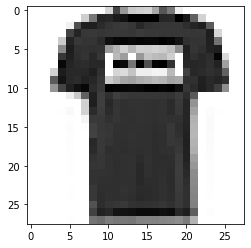

In [19]:
print_title("Image avant normalisation")
print_image_to_matrix(1,train_images)
print_title("Image après normalisation")
tmp = normalization(train_images)
print_image_to_matrix(1,tmp)
print_title("Image correspondante")
img_to_plt(1,train_images).show()

## "Reshaping"

Il nous reste un dernier prétraitement à réaliser. Nous allons changer le format des images afin qu'elles puissent être acceptées en entrée de notre réseau de neurones artificiels. Notre réseau de neurones prend en entrée des tenseurs. Comme chaque image est représentée par une matrice $28 \times 28$, nous allons les convertir en tenseur $ 28 \times 28 \times 1 $. 

In [20]:
def reshape(images):
    """
    
    Reshape images in order to be usable for keras neural network
    
    Parameters
    ----------
    images : 
        Array of images
     
    Returns
    ----------
    numpy.ndarray
    
    """
    image_data_format = K.image_data_format()
    if image_data_format == 'channels_first':
        return images.reshape((-1, 1, images.shape[1], images.shape[2]))
    else:
        return images.reshape((-1, images.shape[1], images.shape[2], 1))

def get_input_shape(images) :
    """
    
    Get the shape of images
    
    Parameters
    ----------
    images : 
        Array of images
     
    Returns
    ----------
    numpy.ndarray
    
    """
    image_data_format = K.image_data_format()
    if image_data_format == 'channels_first':
        return (1, images.shape[1], images.shape[2])
    else:
        return (images.shape[1], images.shape[2],1)
    


In [21]:
INPUT_SHAPE = get_input_shape(train_images)
print_title("Format avant \"Reshaping\"")
print("Ensemble des images d'entraînement :", train_images.shape)
print_title("Format après \"Reshaping\"")
print("Ensemble des images d'entraînement :", reshape(train_images).shape)


+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~~ Format avant "Reshaping" ~~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

Ensemble des images d'entraînement : (60000, 28, 28)

+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~~ Format après "Reshaping" ~~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

Ensemble des images d'entraînement : (60000, 28, 28, 1)


## Résumé 

On définit enfin des fonctions qui permettront de réaliser toutes ces étapes de prétraitement (encodage One-Hot, normalisation, "reshaping").

In [22]:
def preprocess_images(images) :
    """
    
    Return preprocessed images 
    -> Normalization
    -> Reshaping
    
    Parameters
    ----------
    images : 
        Array of images
     
    Returns
    ----------
    numpy.ndarray
    
    """
    images = normalization(images)
    images = reshape(images)
    return images
    
def preprocess(images, labels) :
    """
    
    Return preprocessed images and labels
    
    Images
    -> Normalization
    -> Reshaping
    
    Labels
    -> One-Hot Encoding
    
    Parameters
    ----------
    images : 
        Array of images
    labels : 
        Array of corresponding labels
     
    Returns
    ----------
    numpy.ndarray , numpy.ndarray
    
    """
    labels = OHE(labels)
    images = preprocess_images(images)
    return images,labels

# Notre modèle de départ : "CNN par défaut"

Maintenant nous avons défini nos fonctions de prétraitement, nous pouvons enfin définir notre premier réseau de neurones artificiels. La première architecture que nous allons réaliser est celle du réseau neuronal convolutif suggéré par l'énoncé. À partir de maintenant, nous allons appeler cette architecture : "**Le modèle CNN par défaut**".

## Création de l'architecture 

L'architecture suggérée par l'énoncé, que nous appelons "Modèle CNN par défaut" est la suivante : 

> - Couche de **convolution** à $64$ filtres de forme $5 \times 5$ et activation 'ReLU'
> - Couche de **Max Pooling** de forme $2 \times 2$
> - Couche de **Dropout** avec probabilité $0.25$
>
> - Couche de **convolution** à $128$ filtres de forme $5 \times 5$ et activation 'ReLU'
> - Couche de **Max Pooling** de forme $2 \times 2$
> - Couche de **Dropout** avec probabilité $0.25$
>
> - Couche de **convolution** à $256$ filtres de forme $3 \times 3$ et activation 'ReLU'
> - Couche de **Max Pooling** de forme $2 \times 2$
> - Couche de **Dropout** avec probabilité $0.25$
>
> - Couche **dense** à $256$ neurones
> - Couche de **Dropout** avec probabilité $0.5$
> - Couche de perte avec activation **softmax**

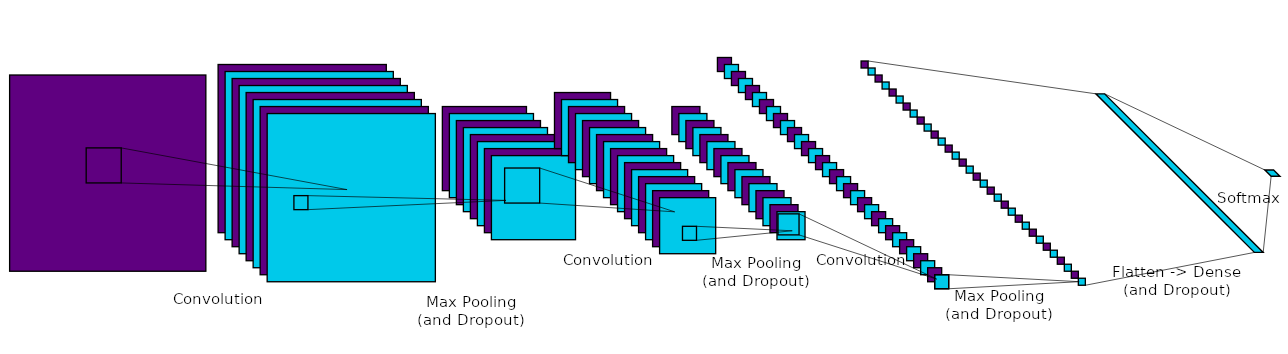

Au préalable, on va définir des fonctions qui vont nous permettre de sauvegarder nos modèles, et de les charger si besoin.

In [23]:
def save_model(model,history,name) :
    """
    
    Save the model and the history
    
    Parameters
    ----------
    name :
        name of the model
    model : 
        the model
    history : 
        history of the model
    
    """
    model.save(FILE_PATH+f'model_{name}.h5')
    if history != None :
        with open(FILE_PATH+f'history_{name}.pkl', 'wb') as f:
            pkl.dump(history.history, f)
    else : 
        with open(FILE_PATH+f'history_{name}.pkl', 'wb') as f:
            pkl.dump("0", f)

def my_load_model(name) :
    """
    
    Load the model and the history
    
    Parameters
    ----------
    name :
        name of the model
    
    Returns
    ----------
    model, history
    
    """
    model = load_model(FILE_PATH+f"model_{name}.h5")
    with open(FILE_PATH+f"history_{name}.pkl", "rb") as f:
        history = pkl.load(f)
    return model, history

def my_load_model_full(name) :
    """
    
    Load the model, epochs, accuracy, val_accuracy, loss and val_loss histories
    
    Parameters
    ----------
    name :
        name of the model
    
    Returns
    ----------
    model, epochs, accuracy, val_accuracy, loss and val_loss
    
    """
    model_cnn, history_cnn = my_load_model(name)
    epoch = np.arange(1,len(history_cnn["accuracy"])+1)
    accuracy = history_cnn["accuracy"]
    val_accuracy = history_cnn["val_accuracy"] 
    loss = history_cnn["loss"]
    val_loss = history_cnn["val_loss"] 
    return model_cnn, epoch, accuracy, val_accuracy, loss, val_loss

def model_exists(name) : 
    """
    Verify if the model exists in files
    
    Parameters
    ----------
    name :
        name of the model
    
    Returns
    ----------
    bool
    """
    return os.path.exists(FILE_PATH+f"model_{name}.h5") \
        and os.path.exists(FILE_PATH+f"history_{name}.pkl")

On définit maintenant nos fonctions permettant de créer le modèle CNN par défaut, et de l'entraîner.

In [24]:
def fit_NN(model, X_train, y_train, X_valid, y_valid, epochs=100, 
           verbose=0, early_stop=False, patience=3, batch_size=64):
    """
    
    Fit the model
    
    Parameters
    ----------
    model :
       the model
    X_train :
        images for training
    y_train : 
        label for labels
    X_valid :
        images for validation
    y_valid :
        labels for validation
    epochs :
        number of epochs (default 100)
    verbose :
        print details (default 0)
    early_stop :
        activate early stopping or not (default : False)
    patience :
        number of epochs before early stopping
    batch_size :
        size of the batchs (default 64)
    
    Returns
    ----------
    model, epochs, accuracy, val_accuracy, loss and val_loss
    
    """
    # Fix randomness for reproductibility
    tf.random.set_seed(75)
    seed(75)

    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=verbose,
        validation_data=(X_valid, y_valid),
        callbacks = [tf.keras.callbacks.EarlyStopping(patience=patience)] \
            if early_stop else None
    ) 

    epoch = history.epoch
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"] 
    loss = history.history["loss"]
    val_loss = history.history["val_loss"] 

    return model, epoch, accuracy, val_accuracy, loss, val_loss, history

def create_default_CNN(name="", param_name=None, param_value=None) :
    """
    Create the default CNN model
    
    Parameters
    ----------
    name :
        name of the model
    param_name :
        name of the hyperparameter to test
    param_value :
        value of the hyperparameter to test
    
    Returns
    ----------
    model
    
    """
    # Fix randomness for reproductibility
    tf.random.set_seed(75) 
    seed(75)
    # If specified, Hyperparameters to test. Else, default values
    input_shape = INPUT_SHAPE
    units = param_value if param_name=="units" else 256
    kernel_size = param_value \
        if param_name=="kernel_size" else [(5,5),(5,5),(3,3)]
    filters = param_value if param_name=="filters" else [64,128,256]
    learning_rate = param_value if param_name=="learning_rate" else 0.0001 
    dropout_rate = param_value \
        if param_name=="dropout_rate" else [ 0.25 , 0.25, 0.25 , 0.5 ]
    pool_size = param_value if param_name=="pool_size" else (2,2)
    # Neural Network
    model_cnn = Sequential(name="DefaultCNN_"+name)
    model_cnn.add(Conv2D(filters[0], kernel_size=kernel_size[0],
                         activation='relu', input_shape=input_shape, 
                         name='Convolu_1'))
    model_cnn.add(MaxPooling2D(pool_size=pool_size, name='MaxPool_1'))
    model_cnn.add(Dropout(dropout_rate[0], name='Dropout_1'))
    model_cnn.add(Conv2D(filters[1], kernel_size=kernel_size[1], 
                         activation='relu', name='Convolu_2'))
    model_cnn.add(MaxPooling2D(pool_size=pool_size, name='MaxPool_2'))
    model_cnn.add(Dropout(dropout_rate[1], name='Dropout_2'))
    model_cnn.add(Conv2D(filters[2], kernel_size=kernel_size[2], 
                         activation='relu', name='Convolu_3'))
    model_cnn.add(MaxPooling2D(pool_size=pool_size, name='MaxPool_3'))
    model_cnn.add(Dropout(dropout_rate[2], name='Dropout_3'))
    model_cnn.add(Flatten(name='Flatten_1')) 
    model_cnn.add(Dense(units, activation='relu', name='Densely_1'))
    model_cnn.add(Dropout(dropout_rate[3], name='Dropout_4'))
    model_cnn.add(Dense(NB_CLASSES, activation='softmax', name='Softmax'))
    model_cnn.compile(loss=losses.categorical_crossentropy,
                    optimizer=optimizers.Adam(learning_rate=learning_rate),
                    metrics=['accuracy'])
    return model_cnn



def create_and_fit_CNN(X_train, y_train, X_valid, y_valid, 
                       epochs=100, name="", param_name=None, 
                       param_value=None, early_stop=False) :
    """
    Create the default CNN model and fit the model
    
    Parameters
    ----------
    X_train, y_train, X_valid, y_valid :
        train and valid datasets
    epochs : 
        number of epochs
    name :
        name of the model
    param_name :
        name of the hyperparameter to test
    param_value :
        value of the hyperparameter to test
    early_stop :
        if True, do early stopping
    
    Returns
    ----------
    model, epochs, accuracy, val_accuracy, loss and val_loss
    
    """
    print_title("Entrainement du réseau neuronal "+name)
    model_cnn = create_default_CNN(name=name,param_name=param_name,
                                 param_value=param_value)
    batch_size = param_value if param_name == "batch_size" else 64 
    return fit_NN(model_cnn,X_train, y_train,X_valid, y_valid,
                  epochs=epochs,verbose=1, early_stop=early_stop, 
                  batch_size=batch_size)

Enfin, on définit des fonctions de visualisation (affichage des hyperparamètres du modèle, courbe d'apprentissage).

In [25]:
def plot_acc_loss(epochs, acc, val_acc, loss, val_loss, title='', 
                  multiple=False, labels=None, training=True) :
    """
    Plot the loss and accuracy curves
    
    Parameters
    ----------
    epochs :
        list of epochs
    acc :
        list of accuracies
    val_acc :
        list of validation accuracies
    loss :
        list of losses
    val_loss :
        list of validation losses
    title :
        title of the plot
    multiple :
        If True, plot multiple curve. Else, only one curve
    labels :
        Names of labels for curves 
    training :
        If True, plot training and accuracy curve. Else, only accuracy
    
    Returns
    ----------
    matplotlib.pyplot
    
    """
    if not multiple :
        i = 2
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))
        if training : axs[0].plot(epochs, acc, lw=2, label='Train set', 
                                c=COLORS_3[0], linestyle=":")
        axs[0].plot(epochs, val_acc, lw=2, label='Valid set', c=COLORS_3[2])
        axs[0].set_title('Précision en fonction des epochs')
        axs[0].set_xlabel("Nombre d'epoch")
        axs[0].set_ylabel('Précision')
        if training : axs[1].plot(epochs, loss, lw=2, c=COLORS_3[0], linestyle=":")
        axs[1].plot(epochs, val_loss, lw=2, c=COLORS_3[2])
        axs[1].set_title("Perte en fonction des epochs")
        axs[1].set_xlabel("Nombre d'epoch")
        axs[1].set_ylabel('Perte')
    else :
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))
        i = 0
        for acc , loss , val_acc , val_loss in zip( acc, loss, val_acc, val_loss) :
            i += 1
            if training : axs[0].plot(epochs, acc, lw=1, label=f''+labels[i-1], 
                                      c=COLORS_5[i-1], linestyle=":")
            axs[0].plot(epochs, val_acc, lw=1, label=f''+labels[i-1], 
                        c=COLORS_5[i-1])
            axs[0].set_title('Précision en fonction des epochs')
            axs[0].set_xlabel("Nombre d'epoch")
            axs[0].set_ylabel('Précision')
            if training : axs[1].plot(epochs, loss, lw=1, c=COLORS_5[i-1], 
                                      linestyle=":")
            axs[1].plot(epochs, val_loss, lw=1, c=COLORS_5[i-1])
            axs[1].set_title("Perte en fonction des epochs")
            axs[1].set_xlabel("Nombre d'epoch")
            axs[1].set_ylabel('Perte')
    fig.legend(bbox_to_anchor=(0.5, -0.02), loc='lower center', ncol=i)
    fig.suptitle(title)
    fig.show()
    return 

def print_params(model) :
    """
    Print hyperparameters of the model
    
    Parameters
    ----------
    model :
        the model
    
    """
    print_title("Architecture détaillée")
    model.summary()
    print_title("Hyperparamètres")
    for layer in model.layers :
        if 'conv' in layer.name.lower() :
            print('\n'+layer.name,'\t'+str(layer.filters)+' filters', 
                  '\tkernel_size '+str(layer.kernel_size),
                  '\tstrides '+str(layer.strides) if layer.strides!=(1,1) else '')
        elif 'pool' in layer.name.lower() :
            print(layer.name,'\tpool_size '+str(layer.pool_size))
        elif 'drop' in layer.name.lower() :
            print(layer.name,'\trate '+str(layer.rate))
        elif 'dense' in layer.name.lower() :
                print('\n'+layer.name,'\t'+str(layer.units)+' units')
        elif 'softmax' in layer.name.lower() :
                print('\n'+layer.name,'\t'+str(layer.units)+' units')
    return

On peut vérifier que l'architecture du modèle est bien conforme à ce qui était suggéré par l'énoncé.

In [26]:
print_params(create_default_CNN())


+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~~~ Architecture détaillée ~~~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

Model: "DefaultCNN_"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Convolu_1 (Conv2D)           (None, 24, 24, 64)        1664      
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 12, 12, 64)        0         
_________________________________________________________________
Dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
Convolu_2 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 4, 4, 128)         0         
_________________

## Création du jeu de validation

Avant d'entrainer notre modèle, on doit d'abord créer nos données de validation. Les données de validation serviront au réseau de neurones pour s'autoévaluer et ajuster ses paramètres (poids et biais) au fil du temps.

On va créer nos données de validation à partir d'un sous-ensemble de nos données d'entraînement.

Au départ, nous n'avions qu'un jeu de données d'entraînement, et un jeu de données de test.

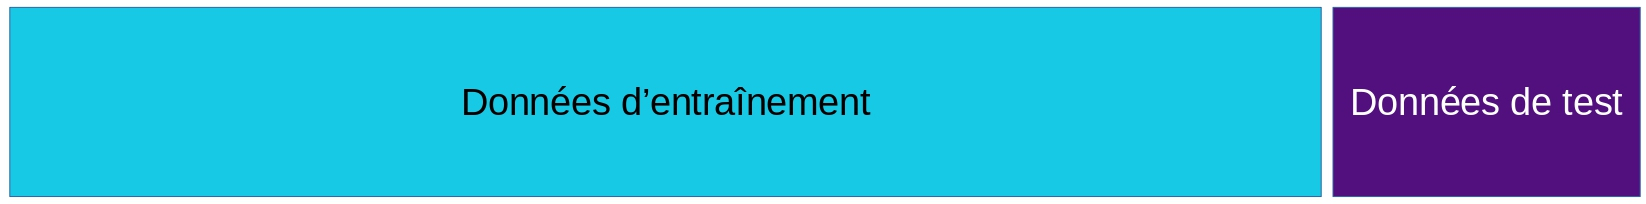

Maintenant, nous avons en plus un jeu de données de validation.

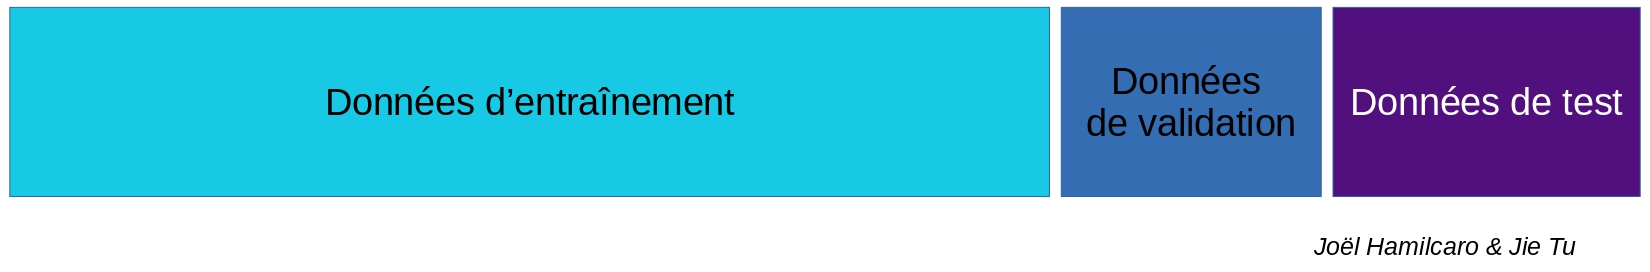

Comme précédemment, on peut observer la distribution des données de validation et des données d'entraînement.

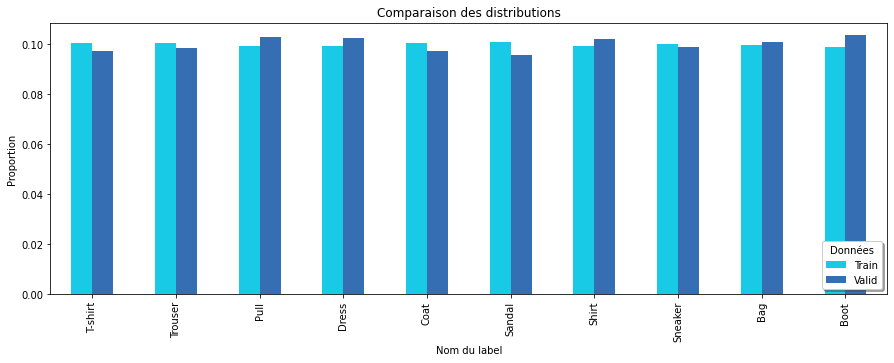

In [27]:
X_train, X_valid, y_train, y_valid = train_test_split(train_images,
                                                      train_labels, 
                                                      test_size = 0.2, 
                                                      random_state=75)

df_train_split_prop = df_labels_distribution(X_train,y_train)
df_valid_split_prop = df_labels_distribution(X_valid,y_valid)

plt_distribution(df_train_split_prop,df_valid_split_prop,valid=True).show()

On peut voir que les données d'entraînement et de validation sont de distribution "quasi"-uniforme. Toutes les classes sont quantitativement bien représentés.

On peut maintenant préparer nos données pour l'entraînement.

In [28]:
X_train, y_train = preprocess(X_train,y_train)
X_valid, y_valid = preprocess(X_valid,y_valid)

## Entraînement


Nous avons maintenant tous les éléments pour entraîner ce premier modèle.

In [29]:
def create_train_save_load(X_train, y_train, X_valid, y_valid, 
                           name, func, **kwargs) :
    """
    Create train and save the model, or load the model if exists
    
    Parameters
    ----------
    name :
        name of the model
    func :
        function for create and fit the model
    kwargs :
        arguments for function
        
    Returns
    ----------
    model, epoch, accuracy, val_accuracy, loss, val_loss 
    
    """
    if model_exists(name) : 
        model, epoch, accuracy, val_accuracy, loss, val_loss \
            = my_load_model_full(name)
    else :
        model, epoch, accuracy, val_accuracy, loss, val_loss, history \
            = func(X_train, y_train, X_valid, y_valid, name=name,**kwargs)
        save_model(model,history,name)
    return model, epoch, accuracy, val_accuracy, loss, val_loss 

In [30]:
model, epoch, accuracy, val_accuracy, loss, val_loss \
    = create_train_save_load(X_train, y_train, X_valid, y_valid, 
                             name="cnn",func=create_and_fit_CNN,epochs=100)

On peut observer l'evolution de la précision et de la perte en fonction des epochs.

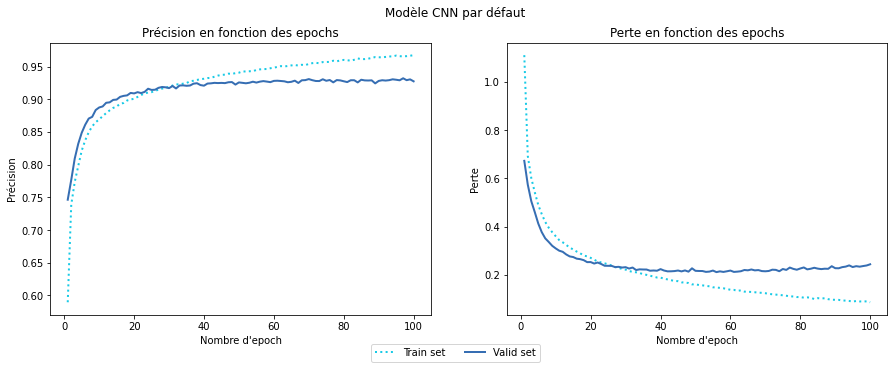

In [31]:
plot_acc_loss(epoch, accuracy, val_accuracy, loss, val_loss, 
              title='Modèle CNN par défaut', training=True)

Sur la courbe de précision pour le jeu de validation, on peut voir qu'on atteint un "plateau" au bout une vingtaine d'épochs (alors que la précision sur le jeu d'entraînement continue d'augmenter). Ce plateau indique qu'il semble difficile de dépasser un certain seuil de précision. Sur le graphique de droite, on constate un léger overfitting. En effet, la courbe de perte augmente lentement à partir d'une vingtaine d'itération, alors que la perte sur le jeu d'entraînement continue de diminuer.

## Évaluation du modèle

### Un exemple de prédiction

On peut désormais évaluer ce premier modèle sur notre jeu de test. On demande au modèle de prédire une classe pour une image appartenant au jeu de test.

In [32]:
def show_prediction(y_pred, i, X_test) :
    """
    Show a prediction
    
    Parameters
    ----------
    y_pred :
        prediction
    i :
        index
    """
    print_title("Image :")
    img_to_plt(i,X_test).show()
    print_title("Probabilité par classe :")
    for key,val in label_dict.items() :
        print(f'{val} : %.4f' % y_pred[i][key] )
    print_title("Prédiction : ") 
    print(label_dict[np.argmax(y_pred[i])].upper())  
    return
    
def example_prediction(y_pred, X_test) :
    """
    Show an example of prediction
    
    Parameters
    ----------
    y_pred :
        prediction
    """
    seed(22)
    i = np.random.randint(0,len(X_test))
    show_prediction(y_pred, i, X_test)
    return


+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Image : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+



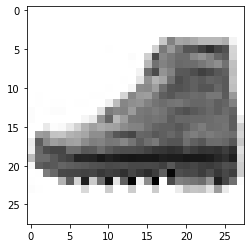


+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~~ Probabilité par classe : ~~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

T-shirt : 0.0000
Trouser : 0.0000
Pull : 0.0000
Dress : 0.0000
Coat : 0.0000
Sandal : 0.0000
Shirt : 0.0000
Sneaker : 0.0033
Bag : 0.0000
Boot : 0.9967

+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Prédiction :  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

BOOT


In [33]:
X_test, y_test = preprocess(test_images,test_labels)
y_pred = model.predict(X_test)
example_prediction(y_pred, X_test)

Cet exemple de prédiction est correct.

### Score sur le jeu de test

Maintenant, on va évaluer notre modèle sur l'ensemble des données du jeu de test. Les métriques que nous allons utiliser pour l'évaluation (générale) sont les suivantes : 
- la **précision** 
- la **perte**

De plus, pour chaque classe, on va regarder quelles sont les types de vêtements difficiles à distinguer. **On va le montrer visuellement à travers des matrices de confusion**. Pour chaque classe, on va de plus évaluer la **précision**, le **rappel**, et le **F-Score**.

In [34]:
def append_evaluation(df,model,X_test,y_test,y_pred) :
    """
    Appends results test in the dataframe 
    
    Parameters
    ----------
    df :
        dataframe
    model :
        model
    X_test :
        test images
    y_test :
        test labels
    y_pred :
        predicted labels
        
    Returns
    ----------
    dataframe
    
    """
    score = model.evaluate(X_test, y_test, verbose=0)
    new_row = {'Model': model.name, 'Accuracy': score[1], 'Loss' : score[0]}
    return df.append(new_row, ignore_index=True)

def show_evaluation(model, X_test, y_test, y_pred) :
    """
    Show confusion matrix
    
    Parameters
    ----------
    model :
        model
    X_test :
        test images
    y_test :
        test labels
    y_pred :
        predicted labels
        
    Returns
    ----------
    dataframe
    
    """
    score = model.evaluate(X_test, y_test, verbose=0)
    print_title('Perte sur le jeu de test :')
    print('%.4f' % score[0])
    print_title('Précision sur le jeu de test :')
    print('%.4f' % score[1])
    pred_classes = np.argmax(y_pred,axis = 1)
    true_classes = np.argmax(y_test,axis = 1)
    print_title('Matrice de confusion et métriques de classification :')
    cmat = confusion_matrix( pred_classes , true_classes, normalize=None ) 
    f,ax = plt.subplots(figsize=(15,5))
    sns.heatmap(cmat, annot=True, fmt= '.0f', 
                xticklabels=label_dict.values(), 
                yticklabels=label_dict.values(), cmap="Purples")
    plt.xlabel("Classes prédites")
    plt.ylabel("Vraies classes")
    plt.title("Matrice de confusion")
    plt.show()
    target_names = [label_dict[i] for i in range(NB_CLASSES)]
    x = classification_report(true_classes, pred_classes, 
                              target_names=target_names, digits=4, 
                              output_dict=True, zero_division=0)
    df = pd.DataFrame(x)[ label_dict.values() ].head(3)
    display(df.style.background_gradient(axis=1, cmap='Purples'))
    return

In [35]:
df = pd.DataFrame()
df["Model"] = None
df["Accuracy"] = None
df["Loss"] = None
df = append_evaluation(df,model,X_test,y_test,y_pred)


+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~ Perte sur le jeu de test : ~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

0.2683

+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~ Précision sur le jeu de test : ~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

0.9221

+---------------------------------------------------------------------------+
¦~~~~~~~~~~ Matrice de confusion et métriques de classification : ~~~~~~~~~~¦
+---------------------------------------------------------------------------+



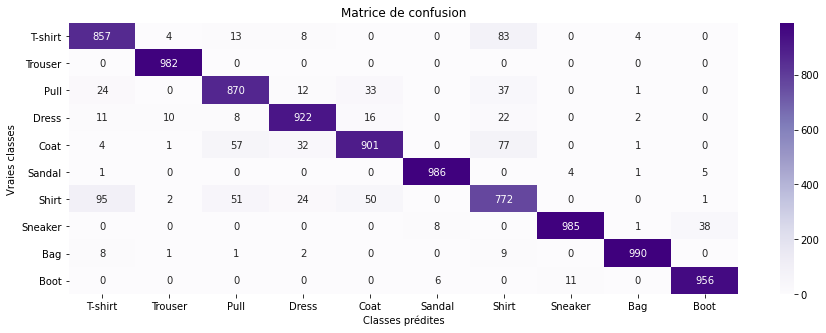

,T-shirt,Trouser,Pull,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Boot
precision,0.884417,1.000000,0.890481,0.930373,0.839702,0.988967,0.775879,0.954457,0.979228,0.982528
recall,0.857000,0.982000,0.870000,0.922000,0.901000,0.986000,0.772000,0.985000,0.990000,0.956000
f1-score,0.870493,0.990918,0.880121,0.926168,0.869272,0.987481,0.773935,0.969488,0.984585,0.969083


In [36]:
show_evaluation(model, X_test, y_test, y_pred)

<div class='alert alert-info' role='alert'><p>
    
Ce premier modèle a des scores très satisfaisants (précision de plus de **92%**)

</p></div>

*   Comme le montre la matrice de confusion il y a peu de confusions
*   Les quelques confusions que l'on peut observer sont les suivantes : 
    - Quelques confusions entre Shirt et T-shirt
    - Des confusions entre les hauts du corps de manière générale : Shirt, T-shirt, Pull , Dress, Coat
    - Quelques confusions entre Boot et Sneakers
    
Cela peut s'expliquer logiquement par la forme similaire entre les différentes classes de haut du corps et les différentes classes de chaussures.

<div class='alert alert-info' role='alert'><p>

On peut observer que le modèle a le plus de difficultés pour les prédictions concernant les chemises (Shirt).

</p></div>

On peut expliquer cela par le fait que pour identifier une chemise, on a besoin d'observer certains détails de l'image (comme le col). Contrairement aux autres classes de vêtement qui s'identifient facilement à partir de leur forme.

## Ajustement manuel des hyperparamètres


Nous allons maintenant essayer d'améliorer notre modèle en ajustant les hyperparamètres manuellement. Cela nous permettra de discuter des différents effets qu'auront les hyperparamètres sur les performances du modèle.

D'abord, on va définir quelques fonctions utiles pour nos ajustements d'hyperaparamètres.

In [37]:
def test_hyperparameters(param_values, param_name, name_func) :
    """
    
    Appends results test in the dataframe 
    
    Parameters
    ----------
    param_values :
        value of parameter to test
    param_name :
        name of parameter to test
    name_func :
        function to create name
        
    Returns
    ----------
    model_cnn_list,epoch_list,accuracy_list,val_accuracy_list,loss_list,val_loss_list
    
    """
    model_cnn_list = []
    epoch_list = []
    accuracy_list = []
    val_accuracy_list = []
    loss_list = []
    val_loss_list = []
    for param_value in param_values :
        name = name_func(param_value)
        if model_exists(name) :
            model_cnn, epoch, accuracy, val_accuracy, \
            loss, val_loss = my_load_model_full(name)
        else :
            model_cnn, epoch, accuracy, val_accuracy, \
                loss, val_loss, history_cnn \
                = create_and_fit_CNN(X_train, y_train, X_valid, y_valid,
                                     epochs=100, name=name,
                                     param_name=param_name,param_value=param_value)
            save_model(model_cnn,history_cnn,name)
        model_cnn_list.append(model_cnn)
        epoch_list.append(epoch)
        accuracy_list.append(accuracy)
        val_accuracy_list.append(val_accuracy)
        loss_list.append(loss)
        val_loss_list.append(val_loss)
    return model_cnn_list,epoch_list,accuracy_list,val_accuracy_list, \
            loss_list,val_loss_list


def plot_hyperparameters(model_cnn_list,epoch_list,accuracy_list,val_accuracy_list,loss_list,val_loss_list,param_values, training=False) :
    """
    
    Plot results of hyperparameters tests
    
    Parameters
    ----------
    model_cnn_list :
        list of model
    epoch_list :
        list of epochs
    accuracy_list :
        list of accuracy
    val_accuracy_list :
        list of validation accuracy
    loss_list :
        list of loss
    val_loss_list :
        list of validation loss
    param_values :
        list of parameters values
        
    """
    labels = list(map(lambda x : str(x),param_values))
    plot_acc_loss(epoch_list[0], accuracy_list, val_accuracy_list, loss_list, val_loss_list, title="Impact de l'hyperparamètre "+param_name, multiple=True, training=training, labels=labels)

### Taux d'apprentissage : `learning_rate`

Le premier paramètre que nous allons modifier est le "pas" de notre optimiseur (nous avons choisi l'optimiseur "ADAM"). Dans le modèle précédent, nous avons gardé la valeur par défaut du pas (0.0001).

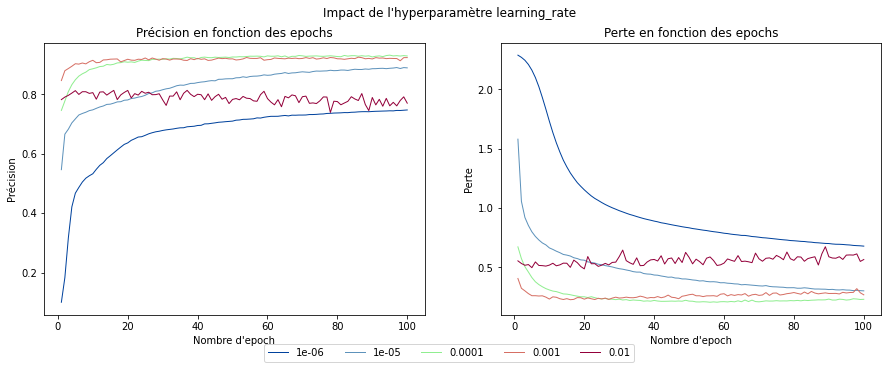

In [38]:
param_values = [0.000001, 0.00001, 0.0001, 0.001, 0.01]
param_name = 'learning_rate'
name_func = lambda x : 'lr'+str(x)
model_cnn_list,epoch_list,accuracy_list, \
    val_accuracy_list,loss_list,val_loss_list \
    = test_hyperparameters(param_values, param_name, name_func)
plot_hyperparameters(model_cnn_list,epoch_list,accuracy_list,
                     val_accuracy_list,loss_list,val_loss_list,param_values)

On peut voir que la valeur par défaut (la valeur 0.0001 représentée en vert), est la meilleure. Une valeur de pas trop grande entraine des perturbations qui empêchent la progression. En revanche, un pas trop petit ne permet pas de progresser de manière efficace. La valeur par défaut est un bon compromis.

### Taille du batch : `batch_size`

On s'intéresse ici à la taille des batchs. Précédemment nous avons utilisé une taille de batch de 64.

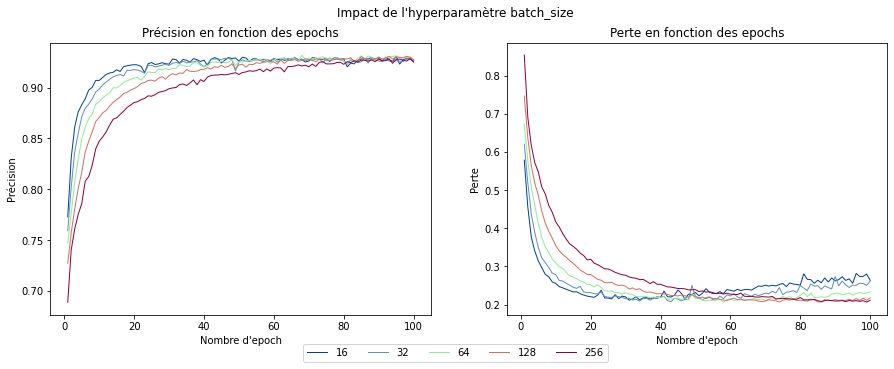

In [39]:
param_values = [16,32,64,128,256]
param_name = 'batch_size'
name_func = lambda x : 'batch'+str(x)
model_cnn_list,epoch_list,accuracy_list,\
    val_accuracy_list,loss_list,val_loss_list \
    = test_hyperparameters(param_values, param_name, name_func)
plot_hyperparameters(model_cnn_list,epoch_list,accuracy_list,
                     val_accuracy_list,loss_list,val_loss_list,param_values)

On peut voir que si la taille du batch est trop petite, on a des perturbations et l'overfitting peut survenir très vite. En revanche si la taille du batch est trop grande, on met beaucoup de temps à atteindre le "plateau". Les valeurs 64 et 128 sont des plutôt bonnes valeurs. 

### Taille des filtres des couches de covolution : `kernel_size`

On va maintenant modifier la taille des filtres des couches de convolution

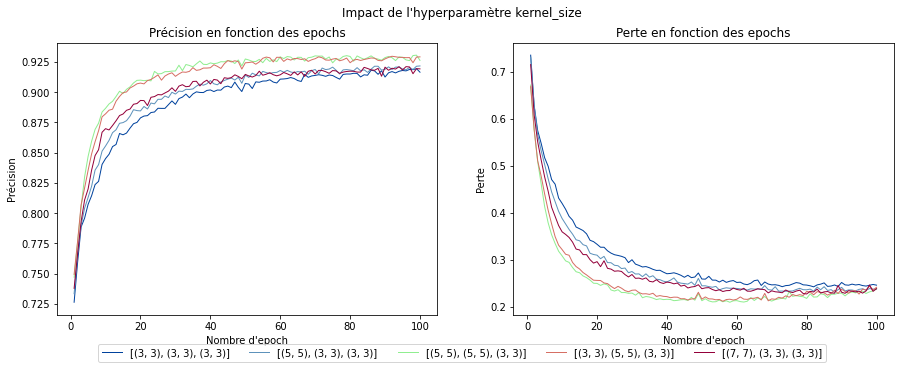

In [40]:
param_values = [[(3,3),(3,3),(3,3)],
                [(5,5),(3,3),(3,3)],
                [(5,5),(5,5),(3,3)],
                [(3,3),(5,5),(3,3)],
                [(7,7),(3,3),(3,3)]]
param_name = 'kernel_size'
name_func = lambda x : 'ks_'+str(x[0][0])+'_'+str(x[1][0])+'_'+str(x[2][0])
model_cnn_list,epoch_list,accuracy_list, \
    val_accuracy_list,loss_list,val_loss_list \
    = test_hyperparameters(param_values, param_name, name_func)
plot_hyperparameters(model_cnn_list,epoch_list,accuracy_list,
                     val_accuracy_list,loss_list,val_loss_list,param_values)

La taille des filtres suggérée en énoncé (5x5, 5x5 et 3x3) nous donne des meilleurs résultats que les autres combinaisons que nous avons testées. 

### Nombre de noyaux : `filters` 

On va maintenant modifier le nombre de filtres des couches de convolution. On va tester les trois patterns suivants :  
- le nombre de filtre augmente avec la profondeur des couches
- le nombre de filtre reste le même pour toutes les couche de convolution
- le nombre de filre diminue avec la profondeur des couches

**Nombres croissants de filtre**

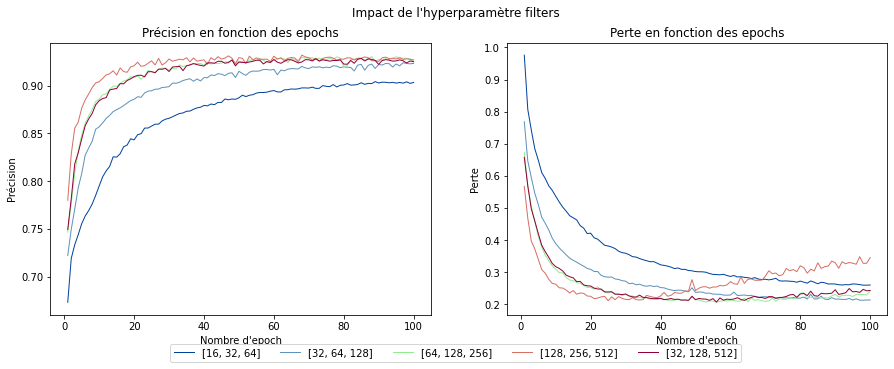

In [41]:
param_values = [[16,32,64] , [32,64,128] , 
                [64,128,256] , [128,256,512], [32, 128, 512] ]
param_name = 'filters'
name_func = lambda x : 'nbk_'+str(x[0])+'_'+str(x[1])+'_'+str(x[2])
model_cnn_list,epoch_list,accuracy_list, \
    val_accuracy_list,loss_list,val_loss_list \
    = test_hyperparameters(param_values, param_name, name_func)
plot_hyperparameters(model_cnn_list,epoch_list,accuracy_list,
                     val_accuracy_list,loss_list,val_loss_list,param_values)

**Nombres constants de filtres**

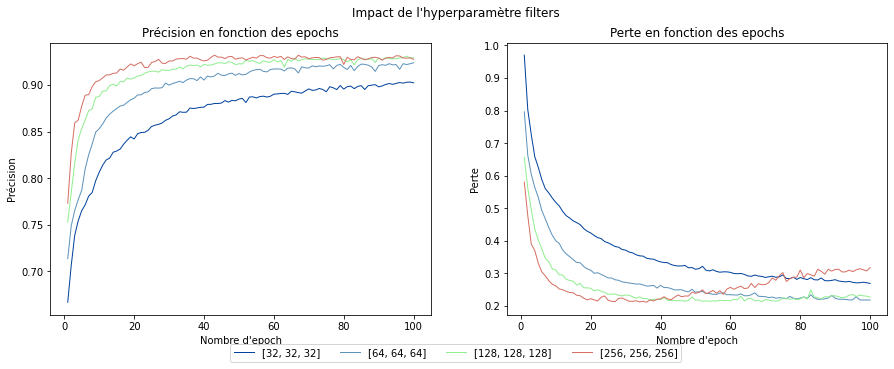

In [42]:
param_values =  [ [32,32,32] , [64,64,64] , [128,128,128] , [256,256,256] ]
model_cnn_list,epoch_list,accuracy_list, \
    val_accuracy_list,loss_list,val_loss_list \
    = test_hyperparameters(param_values, param_name, name_func)
plot_hyperparameters(model_cnn_list,epoch_list,accuracy_list,
                     val_accuracy_list,loss_list,val_loss_list,param_values)

**Nombres décroissants de filtres**

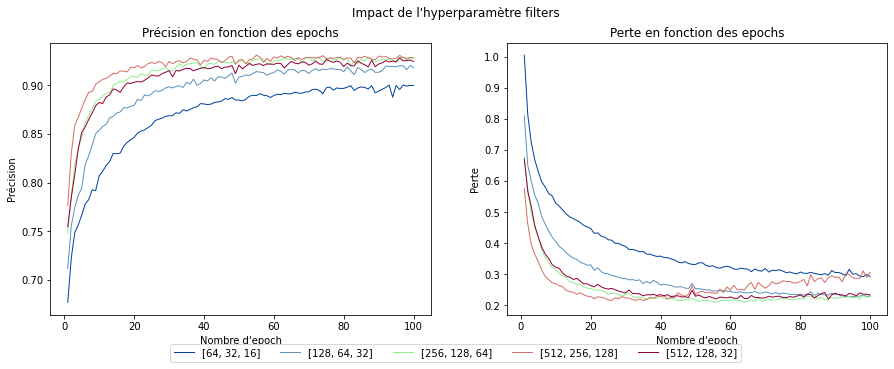

In [43]:
param_values =  [[64,32,16], 
                 [128,64,32], 
                 [256,128,64], 
                 [512,256,128],  
                 [512,128,32] ]
model_cnn_list,epoch_list,accuracy_list, \
    val_accuracy_list,loss_list,val_loss_list \
    = test_hyperparameters(param_values, param_name, name_func)
plot_hyperparameters(model_cnn_list,epoch_list,accuracy_list,
                     val_accuracy_list,loss_list,val_loss_list,param_values)

Dans les trois cas, on obtient des précision et des pertes assez similaires. On peut aussi observer que si le nombre de filtre est trop grand, on observe de l'overfitting. Enfin, si le nombre de filtre est trop petit, le modèle a plus de mal à apprendre (la précision n'augmente pas assez et la perte diminue trop lentement). 

### Dimension en sortie de la couche dense : `units`

Cette fois, on regarde l'impact du nombre de neurones de la couche dense sur notre modèle.

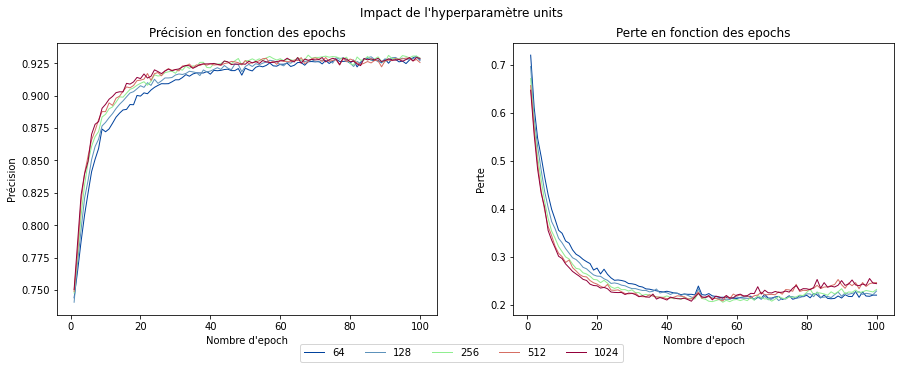

In [44]:
param_values = [64, 128, 256, 512, 1024]
param_name = 'units'
name_func = lambda x : 'units_'+str(x)
model_cnn_list,epoch_list,accuracy_list, \
    val_accuracy_list, loss_list,val_loss_list \
    = test_hyperparameters(param_values, param_name, name_func)
plot_hyperparameters(model_cnn_list,epoch_list,accuracy_list,
                     val_accuracy_list,loss_list,val_loss_list,param_values)

Encore une fois, si la valeur de cet hyperparamètre est trop grand, on observe de l'overfitting. Pour des valeurs très petites (ici 64), on met plus de temps à atteindre le "plateau". De nouveau, la valeur suggérée par l'énoncé est un bon compromis.

### Taux de dropout : `Dropout.rate`

On cherche maintenant à modifier les probabilités de dropout.

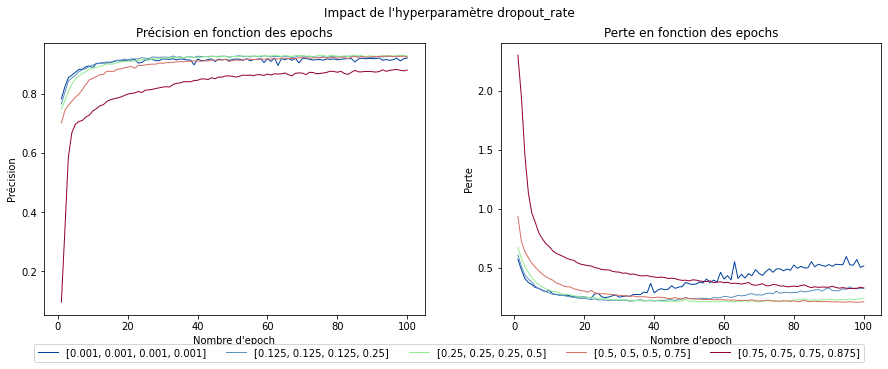

In [45]:
param_values = [
                [0.001, 0.001, 0.001, 0.001 ], 
                [0.125, 0.125, 0.125, 0.25 ], 
                [0.25, 0.25, 0.25, 0.5 ], 
                [0.5, 0.5, 0.5 , 0.75 ], 
                [0.75, 0.75, 0.75, 0.875 ] ]
param_name = 'dropout_rate'
name_func = lambda x : 'drop_'+str(x[0])+"_"+str(x[1])+"_"+str(x[2])+"_"+str(x[3])
model_cnn_list,epoch_list,accuracy_list, \
    val_accuracy_list, loss_list,val_loss_list \
    = test_hyperparameters(param_values, param_name, name_func)
plot_hyperparameters(model_cnn_list,epoch_list,accuracy_list,
                     val_accuracy_list,loss_list,val_loss_list,param_values)

À probabilité très faible de dropout, on observe un flagrant overfitting. Cela s'explique, car si la probabilité de dropout est trop faible, on garde presque toutes les informations, ce qui conduit à du sur-apprentissage. À probabilité élevée, on perd en efficacité (moins de précision et plus de perte). La valeur suggérée par l'énoncé est encore une fois celle qui offre les meilleurs résultats.

### Fenêtre de Max-Pooling `MaxPooling2D.pool_size` 

Pour finir, on va modifier les dimensions des fenêtres de Max Pooling.

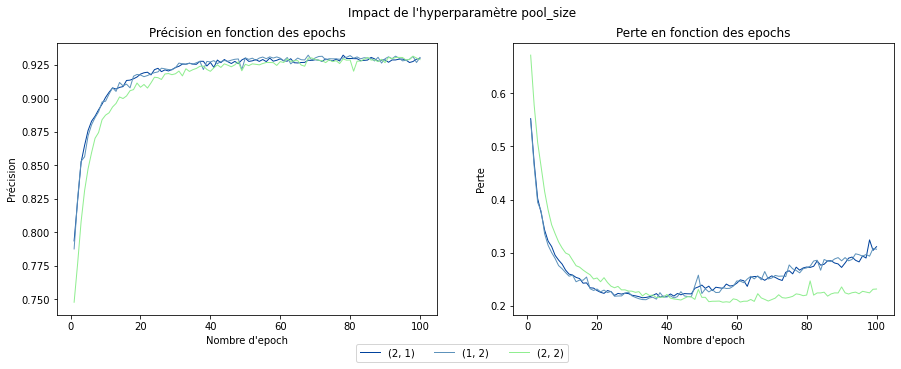

In [46]:
param_values = [ (2,1), (1,2), (2,2) ]
param_name = 'pool_size'
name_func = lambda x : 'pool_'+str(x[0])+'_'+str(x[1])
model_cnn_list,epoch_list,accuracy_list,\
    val_accuracy_list,loss_list,val_loss_list \
    = test_hyperparameters(param_values, param_name, name_func)
plot_hyperparameters(model_cnn_list,epoch_list,accuracy_list,val_accuracy_list,
                     loss_list,val_loss_list,param_values)

Un Max Pooling de taille 2x2 semble être plus performant que ceux de taille 2x1 et 1x2.

## Early-Stopping 

On va maintenant mettre en place l'Early-Stopping pour éviter les phénomènes d'overfitting. L'early-stopping va arrêter l'entraînement lorsque la perte sur le jeu de validation se met à augmenter pendant plusieurs epochs d'affilées.

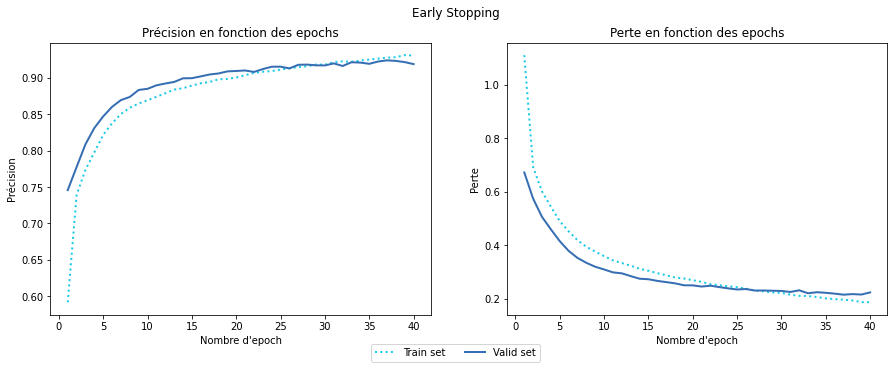

In [47]:
model, epoch, accuracy, val_accuracy, loss, val_loss \
    = create_train_save_load(X_train, y_train, X_valid, y_valid, 
                             name="early_stop_cnn",func=create_and_fit_CNN, 
                             early_stop=True)

plot_acc_loss(epoch, accuracy, val_accuracy , loss, val_loss , 
              title='Early Stopping', training=True)

<div class='alert alert-info' role='alert'><p>
    
On peut donc voir que l'entraînement s'arrête à environ 40 epochs.
    
</p></div>




+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~ Perte sur le jeu de test : ~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

0.2398

+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~ Précision sur le jeu de test : ~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

0.9136

+---------------------------------------------------------------------------+
¦~~~~~~~~~~ Matrice de confusion et métriques de classification : ~~~~~~~~~~¦
+---------------------------------------------------------------------------+



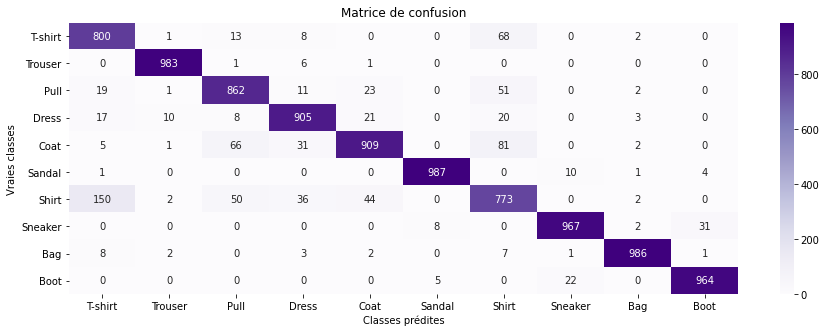

,T-shirt,Trouser,Pull,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Boot
precision,0.896861,0.991927,0.889577,0.919715,0.830137,0.984048,0.731315,0.959325,0.976238,0.972755
recall,0.800000,0.983000,0.862000,0.905000,0.909000,0.987000,0.773000,0.967000,0.986000,0.964000
f1-score,0.845666,0.987443,0.875571,0.912298,0.867780,0.985522,0.751580,0.963147,0.981095,0.968358


In [48]:
y_pred = model.predict(X_test)
df = append_evaluation(df,model,X_test,y_test,y_pred)
show_evaluation(model, X_test, y_test, y_pred)

In [49]:
def compare_models(df) :
    return df.style.background_gradient(axis=0, cmap='Purples', subset=['Accuracy'])\
            .background_gradient(axis=0, cmap='Purples_r', subset=['Loss'])

compare_models(df)

,Model,Accuracy,Loss
0,DefaultCNN_cnn,0.922100,0.268270
1,DefaultCNN_early_stop_cnn,0.913600,0.239828


<div class='alert alert-info' role='alert'><p>
    
Ainsi, on a une perte moins grande que sur le modèle par défaut. Mais on perd légèrement en précision. Les prédictions concernant les chemises (*Shirt*) sont toujours celles qui posent le plus de difficultés.
    
</p></div>




## Recherche automatique d'hyperparamètres

Nous avons vu dans les sections précédentes l'impact des hyperparamètres en modifiant leurs valeurs manuellement. Maintenant, nous allons faire une recherche automatique pour essayer de trouver la meilleure combinaison de valeurs des hyperparamètres. Nous effectuerons une recherche aléatoire (avec `keras_tuner.RandomSearch`). Cette recherche n'est pas exhaustive, car elle ne teste pas toutes les combinaisons possibles. Cependant, elle permet d'obtenir rapidement des résultats satisfaisants. 

Grâce aux ajustements manuels que nous avons faits précédemment, on a une idée des hyperparamètres qu'il peut être pertinent de tester. On va donc se restreindre aux tailles de filtres. En effet, les différentes valeurs donnaient des résultats similaires. Il était difficile de déduire quels étaient les "meilleures" tailles de filtres. Les autres hyperparamètres (pas, taille du batch, taille des noyaux...) seront fixés aux valeurs optimales que nous avons obtenues. Cela permettra d'alléger l'algorithme de recherche automatique qui peut être très couteuse.

In [50]:
def create_tuned_defaultCNN(hp) :
    """
    
    Search best hyperparameters combination for the default CNN architecture
    
    Parameters
    ----------
    hp :
        tuner
  
    Returns
    ----------
    model_cnn
    
    """
    # Fix randomness for reproductibility
    tf.random.set_seed(75) 
    seed(75)
    input_shape = INPUT_SHAPE
    model_cnn = Sequential(name="DefaultCNN_tuned")
    model_cnn.add(
        Conv2D(
            filters=hp.Choice('filters_1',values = [64,128,256]), 
            kernel_size=5, 
            activation='relu', 
            input_shape=input_shape, 
            name='Conv2D_1')
    )
    model_cnn.add(
        MaxPooling2D(
            pool_size=(2,2), 
            name='MaxPool_1')
    ) 
    model_cnn.add(
        Dropout(
            rate=0.25, 
            name='Dropout_1')
    )
    model_cnn.add(
        Conv2D(
            filters=hp.Choice('filters_2',values = [64,128,256]), 
            kernel_size=5, 
            activation='relu', 
            name='Conv2D_2'
        )
    )
    model_cnn.add(
        MaxPooling2D(
            pool_size=(2,2), 
            name='MaxPool_2')
    )
    model_cnn.add(
        Dropout(
            rate=0.25, 
            name='Dropout_2')
    )
    model_cnn.add(
        Conv2D(
            filters=hp.Choice('filters_3',values = [64,128,256]), 
            kernel_size=3, 
            activation='relu', 
            name='Conv2D_3')
    )
    model_cnn.add(
        MaxPooling2D(
            pool_size=(2,2), 
            name='MaxPool_3')
    )
    model_cnn.add(
        Dropout(
            rate=0.25, 
            name='Dropout_3')
    )
    model_cnn.add(
        Flatten(
            name='Flatten_1')
    ) 
    model_cnn.add(
        Dense(
            units=hp.Choice('units', values=[128,256]), 
            activation='relu', 
            name='Dense_1')
    )
    model_cnn.add(
        Dropout(
            rate=0.5, 
            name='Dropout_4')
    )
    model_cnn.add(
        Dense(NB_CLASSES, activation='softmax', name='OUTPUT')
    )
    model_cnn.compile(
        loss=losses.categorical_crossentropy,
        optimizer=optimizers.Adam(learning_rate=0.0001),
        metrics=['accuracy']
    )
    return model_cnn

In [51]:
if model_exists('cnn_tuned') :
    model_cnn, history_cnn = my_load_model("cnn_tuned")
else :
    tuner = kt.RandomSearch(
        create_tuned_defaultCNN,
        objective='val_accuracy',
        max_trials=10
    )
    tuner.search(X_train, y_train, epochs=100, 
                 validation_data=(X_valid, y_valid), 
                 callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                             patience=3)] )
    model_cnn = tuner.get_best_models()[0]
    save_model(model_cnn,None,"cnn_tuned")
    
print_params(model_cnn)


+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~~~ Architecture détaillée ~~~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

Model: "DefaultCNN_tuned"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_1 (Conv2D)            (None, 24, 24, 64)        1664      
_________________________________________________________________
MaxPool_1 (MaxPooling2D)     (None, 12, 12, 64)        0         
_________________________________________________________________
Dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
Conv2D_2 (Conv2D)            (None, 8, 8, 64)          102464    
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 4, 4, 64)          0         
____________

<div class='alert alert-info' role='alert'><p>
    
On veut voir que le meilleur modèle obtenu par la recherche aléatoire utilise de tailles de filtres de **64**, **64** et **256**.    
    
</p></div>




+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~ Perte sur le jeu de test : ~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

0.2286

+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~ Précision sur le jeu de test : ~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

0.9192

+---------------------------------------------------------------------------+
¦~~~~~~~~~~ Matrice de confusion et métriques de classification : ~~~~~~~~~~¦
+---------------------------------------------------------------------------+



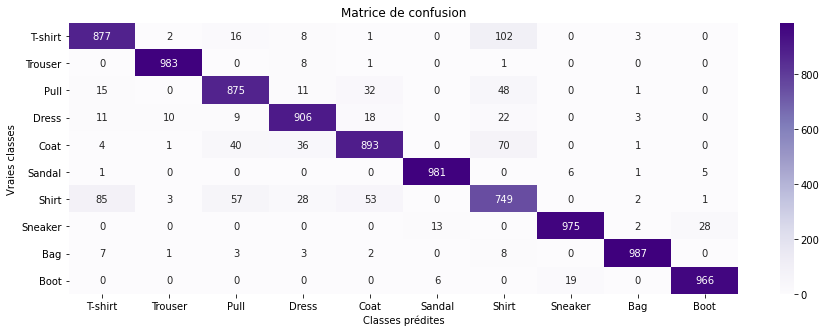

,T-shirt,Trouser,Pull,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Boot
precision,0.869177,0.989930,0.891039,0.925434,0.854545,0.986922,0.765849,0.957760,0.976261,0.974773
recall,0.877000,0.983000,0.875000,0.906000,0.893000,0.981000,0.749000,0.975000,0.987000,0.966000
f1-score,0.873071,0.986453,0.882947,0.915614,0.873350,0.983952,0.757331,0.966303,0.981601,0.970367


In [52]:
y_pred = model_cnn.predict(X_test)
df = append_evaluation(df,model_cnn,X_test,y_test,y_pred)
show_evaluation(model_cnn, X_test, y_test, y_pred)

In [53]:
compare_models(df)

,Model,Accuracy,Loss
0,DefaultCNN_cnn,0.922100,0.268270
1,DefaultCNN_early_stop_cnn,0.913600,0.239828
2,DefaultCNN_tuned,0.919200,0.228566


<div class='alert alert-info' role='alert'><p>
    
On peut voir que les scores obtenus sont quasiment les mêmes que sur le modèle par défaut. On perd très légèrement en précision, mais on a une meilleure perte. Ces différences sont vraiment minimes. Elles peuvent être dues à l'aléa. De plus, les prédictions concernant les chemises (*Shirt*) sont toujours celles qui posent le plus de difficultés.
    
</p></div>

## Augmentation des données

Dans cette section, on va effectuer une augmentation des données (ou *Data augmentation*). Cela consiste à ajouter des nouvelles données d'entraînement en effectuant des transformations sur les images originales (rotation, symétrie, modification du contraste ...). Entraîner le modèle sur les données augmentées peut aider à obtenir de meilleures performances.

On définit ici les fonctions qui permettent d'effectuer la *Data augmentation*.

In [54]:
def transform_image(image) :
    """
    
    Transform an image with random flip and random noise
    
    Parameters
    ----------
    image :
        an image 
  
    Returns
    ----------
    image
    
    """
    flips = { 
        0 : lambda x : x    ,
        1 : tf.image.flip_left_right ,
    }
    decalages = {   
        0 : lambda x : resize_with_crop_or_pad( pad_to_bounding_box(x, 0, 4, 28, 32), 
                                               28,28 ) , 
        1 : lambda x : resize_with_crop_or_pad( pad_to_bounding_box(x, 4, 0, 32, 28), 
                                               28,28 ) , 
        2 : lambda x : resize_with_crop_or_pad( pad_to_bounding_box(x, 4, 4, 32, 32), 
                                               28,28 )
    } 
    gammas = {
        0 : lambda x : x,
        1 : lambda x : adjust_gamma(x, 0.5) ,
        2 : lambda x : adjust_gamma(x, 2) ,
    }
    flip_rand =  np.random.randint(0,len(flips)) 
    decal_rand =  np.random.randint(0,len(decalages)) 
    gamma_rand = np.random.randint(0,len(gammas)) 
    image = decalages[decal_rand](image)
    image = flips[flip_rand](image)
    image = gammas[gamma_rand](image)
    return image
  
def reset_shape(news) :
    """
    
    Resets images to their original shape
    
    Parameters
    ----------
    news :
        an array of new images (transformed)
  
    Returns
    ----------
    an array of images (same format as train_images)
    
    """
    news = np.reshape(np.array(news),(len(news),len(news[0]), len(news[0][0])))
    return news

def augmentation(train_images,train_labels):
    """
    
    Does the data augmentation
    
    Parameters
    ----------
    news :
        an array of new images (transformed)
  
    Returns
    ----------
    an array of images (same format as train_images)
    
    """
    # Fix randomness for reproducibility
    seed(7)
    new_train_images = train_images.copy()
    new_train_labels = train_labels.copy()
    new_train_images = reshape(train_images)
    new_train_images = list( 
        map( transform_image ,  new_train_images )
    )
    new_train_images=reset_shape(new_train_images)
    new_train_images = np.concatenate( (train_images,new_train_images) , axis=0)
    new_train_labels = np.concatenate( (train_labels,new_train_labels) , axis=0)
    return (new_train_images,new_train_labels)

On illustre ici un exemple d'image obtenue après *Data augmentation* :


+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~ Exemple d'image originale ~~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+



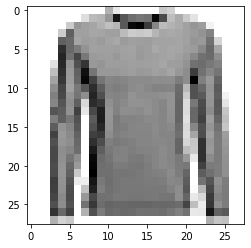


+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~ Exemple d'image obtenue après augmentation ~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+



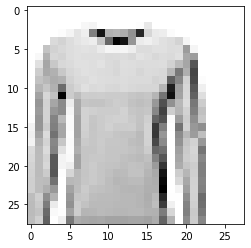

In [55]:
seed(87)
i = np.random.randint(0,len(train_images))
print_title("Exemple d'image originale")
train_images_tmp = reshape(train_images)
img_to_plt(i, images=train_images_tmp).show()
img1 = train_images_tmp[i]
img2 = transform_image( img1 )
train_images_tmp =  [ img2 ] 
train_images_tmp = reset_shape( train_images_tmp )
print_title("Exemple d'image obtenue après augmentation")
img_to_plt(0,train_images_tmp).show()

On créé ci-dessous notre ensemble de données d'entraînement obtenues après *Data augmentation*.

In [56]:
%%time


(train_images_augmented, train_labels_augmented) \
    = augmentation(train_images, train_labels)

CPU times: user 2min 14s, sys: 852 ms, total: 2min 15s
Wall time: 2min 15s



+---------------------------------------------------------------------------+
¦~~~~~~~ Échantillon des données d'entrainement (après augmentation) ~~~~~~~¦
+---------------------------------------------------------------------------+



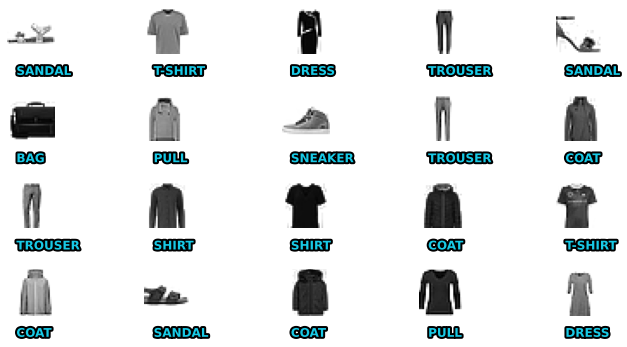

In [57]:
print_title("Échantillon des données d'entrainement (après augmentation)")
plt_sample(4,5,images=train_images_augmented, labels=train_labels_augmented, 
           random_state=75, cmap="gray_r", head_0_tail_1=1).show()

### Entrainement du modèle sur les données augmentées

On entraîne maintenant notre modèle sur les données augmentées.

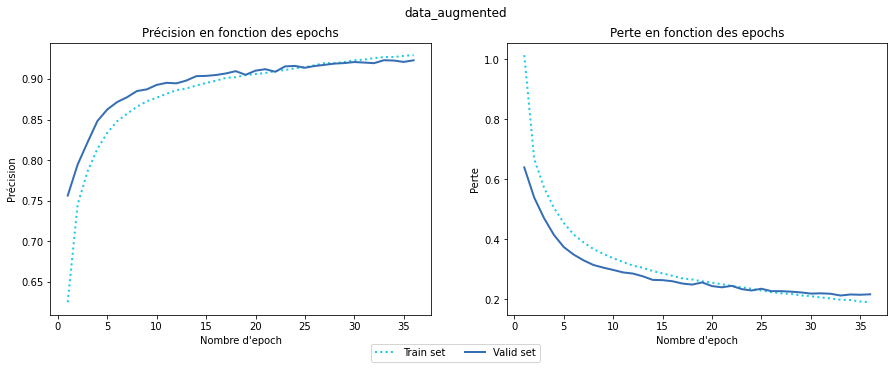

In [58]:
X_train_augmented, X_valid_augmented, y_train_augmented, y_valid_augmented \
    = train_test_split(train_images_augmented,train_labels_augmented, 
                       test_size = 0.2, random_state=75)
X_train_augmented, y_train_augmented = preprocess(X_train_augmented,y_train_augmented)
X_valid_augmented, y_valid_augmented = preprocess(X_valid_augmented,y_valid_augmented)

model, epoch, accuracy, val_accuracy, loss, val_loss \
    = create_train_save_load(X_train_augmented, y_train_augmented,
                             X_valid_augmented, y_valid_augmented,
                             name="data_augmented",
                             func=create_and_fit_CNN, early_stop=True)

plot_acc_loss(epoch, accuracy, val_accuracy , loss, val_loss , 
              title='data_augmented', training=True)


+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~ Perte sur le jeu de test : ~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

0.2182

+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~ Précision sur le jeu de test : ~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

0.9210

+---------------------------------------------------------------------------+
¦~~~~~~~~~~ Matrice de confusion et métriques de classification : ~~~~~~~~~~¦
+---------------------------------------------------------------------------+



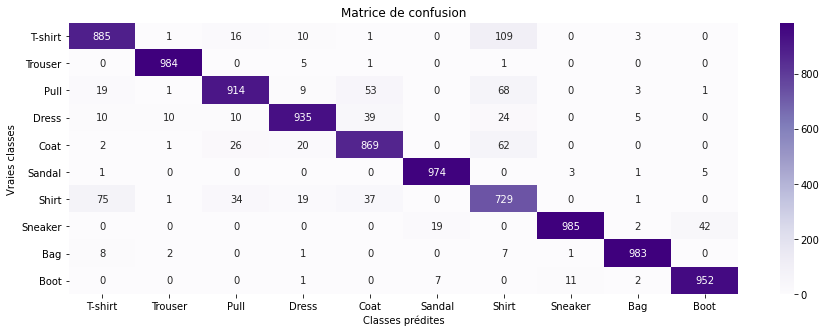

,T-shirt,Trouser,Pull,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Boot
precision,0.863415,0.992936,0.855805,0.905131,0.886735,0.989837,0.813616,0.939885,0.981038,0.978417
recall,0.885000,0.984000,0.914000,0.935000,0.869000,0.974000,0.729000,0.985000,0.983000,0.952000
f1-score,0.874074,0.988448,0.883946,0.919823,0.877778,0.981855,0.768987,0.961914,0.982018,0.965028


In [59]:
y_pred = model.predict(X_test)
df = append_evaluation(df,model,X_test,y_test,y_pred)
show_evaluation(model, X_test, y_test, y_pred)

In [60]:
compare_models(df)

,Model,Accuracy,Loss
0,DefaultCNN_cnn,0.922100,0.268270
1,DefaultCNN_early_stop_cnn,0.913600,0.239828
2,DefaultCNN_tuned,0.919200,0.228566
3,DefaultCNN_data_augmented,0.921000,0.218162


<div class='alert alert-info' role='alert'><p>
    
On obtient ici une meilleure perte que sur le modèle par défaut. On perd légèrement en précision. Ces différences sont de nouveau très minimes.  De plus, les prédictions concernant les chemises (*Shirt*) sont toujours celles qui posent le plus de difficultés.
    
</p></div>

## Résumé

On affiche ici un résumé des différentes performances obtenues en fonction des différents modèles.

In [61]:
compare_models(df)

,Model,Accuracy,Loss
0,DefaultCNN_cnn,0.922100,0.268270
1,DefaultCNN_early_stop_cnn,0.913600,0.239828
2,DefaultCNN_tuned,0.919200,0.228566
3,DefaultCNN_data_augmented,0.921000,0.218162


# Autres architectures 

Dans les sections précédentes, les changements obtenus en modifiant le modèle n'était pas significatifs.

Ici, on va créer des réseau neuronaux avec des architectures différentes, on observe si on obtient des améliorations significatives. 

## Réseau de neurones à propagation avant

Le première architecture que nous allons créer est celle d'un réseaux de neurones à propagation avant (*FFNN*) à trois couches de plus en plus larges.

> - Couche de **dense** à $64$ neurones 
> - Couche de **dense** à $128$ neurones 
> - Couche de **dense** à $256$ neurones 
> - Couche de perte avec activation **softmax**

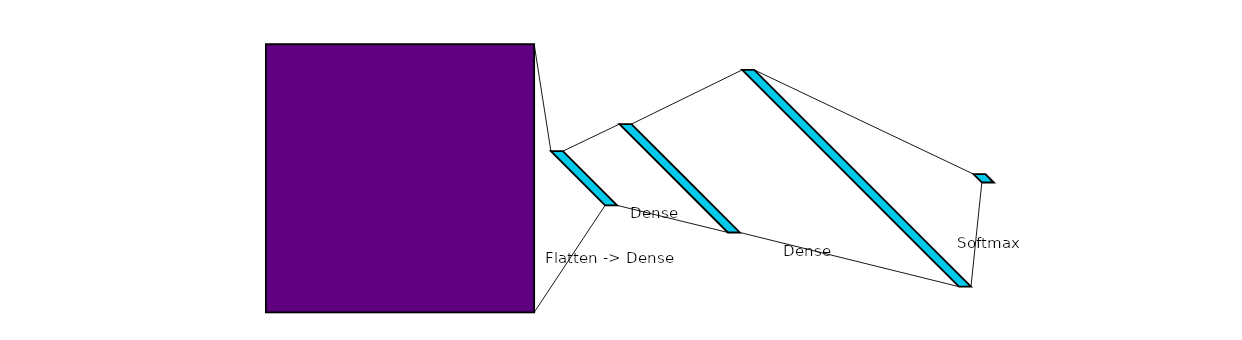

In [62]:
def create_FFNN(name="") :
    """
    
    Create a FFNN model
    
    Parameters
    ----------
    name :
        name of the model
  
    Returns
    ----------
    model_ffnn
    
    """
    # Fix randomness for reproducibility
    tf.random.set_seed(75) 
    seed(75)
    input_shape = INPUT_SHAPE 
    model_ffnn = Sequential(name="FFNN_"+name)
    model_ffnn.add(Flatten(input_shape=input_shape, name='Flatten_1'))
    model_ffnn.add(Dense(64, activation='relu', name='Densely_1'))    
    model_ffnn.add(Dense(128, activation='relu', name='Densely_2'))
    model_ffnn.add(Dense(256, activation='relu', name='Densely_3'))
    model_ffnn.add(Dense(NB_CLASSES, activation='softmax', name='Softmax'))
    model_ffnn.compile(
        loss=losses.categorical_crossentropy,
        optimizer=optimizers.Adam(),
        metrics=['accuracy']
    )
    return model_ffnn

def create_and_fit_FFNN(X_train,y_train,X_valid, y_valid,
                        epochs=100,name="", early_stop=True) :
    """
    Create a FFNN model and fit the model
    
    Parameters
    ----------
    X_train, y_train, X_valid, y_valid :
        train and valid datas
    epochs : 
        number of epochs
    name :
        name of the model
    early_stop :
        if True, do early stopping
    
    Returns
    ----------
    model, epochs, accuracy, val_accuracy, loss and val_loss
    
    """
    print_title("Entrainement du réseau neuronal "+name)
    model_ffnn = create_FFNN(name=name)
    return fit_NN(model_ffnn, X_train, y_train, X_valid, y_valid, 
                  epochs=epochs,verbose=1, early_stop=early_stop)

print_params(create_FFNN())


+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~~~ Architecture détaillée ~~~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

Model: "FFNN_"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
Densely_1 (Dense)            (None, 64)                50240     
_________________________________________________________________
Densely_2 (Dense)            (None, 128)               8320      
_________________________________________________________________
Densely_3 (Dense)            (None, 256)               33024     
_________________________________________________________________
Softmax (Dense)              (None, 10)                2570      
Total params: 94,154
Tr

### Entraînement sur les données initiales

On va entraîner de modèle sur les données de base (sans *Data augmentation*) puis on affiche les scores obtenus.

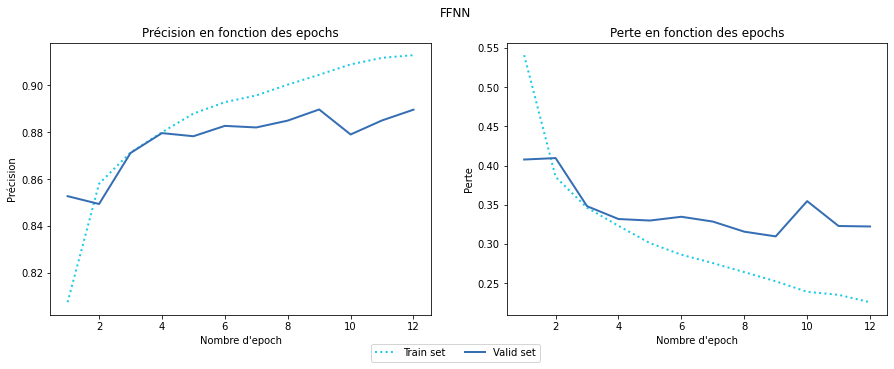

In [63]:
model, epoch, accuracy, val_accuracy, loss, val_loss \
    = create_train_save_load(X_train, y_train, X_valid, y_valid, 
                             name="ffnn",func=create_and_fit_FFNN, 
                             early_stop=True)

plot_acc_loss(epoch, accuracy, val_accuracy , loss, val_loss , 
              title='FFNN', training=True)


+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~ Perte sur le jeu de test : ~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

0.3479

+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~ Précision sur le jeu de test : ~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

0.8772

+---------------------------------------------------------------------------+
¦~~~~~~~~~~ Matrice de confusion et métriques de classification : ~~~~~~~~~~¦
+---------------------------------------------------------------------------+



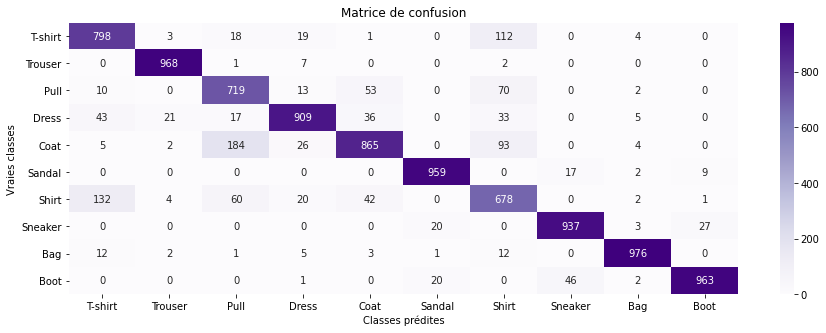

,T-shirt,Trouser,Pull,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Boot
precision,0.835602,0.989775,0.829296,0.854323,0.733673,0.971631,0.722045,0.949341,0.964427,0.933140
recall,0.798000,0.968000,0.719000,0.909000,0.865000,0.959000,0.678000,0.937000,0.976000,0.963000
f1-score,0.816368,0.978766,0.770220,0.880814,0.793942,0.965274,0.699330,0.943130,0.970179,0.947835


In [64]:
y_pred = model.predict(X_test)
df = append_evaluation(df,model,X_test,y_test,y_pred)
show_evaluation(model,X_test,y_test,y_pred)

In [65]:
compare_models(df)

,Model,Accuracy,Loss
0,DefaultCNN_cnn,0.922100,0.268270
1,DefaultCNN_early_stop_cnn,0.913600,0.239828
2,DefaultCNN_tuned,0.919200,0.228566
3,DefaultCNN_data_augmented,0.921000,0.218162
4,FFNN_ffnn,0.877200,0.347898


### Entraînement sur les données augmentées

On fait de même avec les données augmentées.

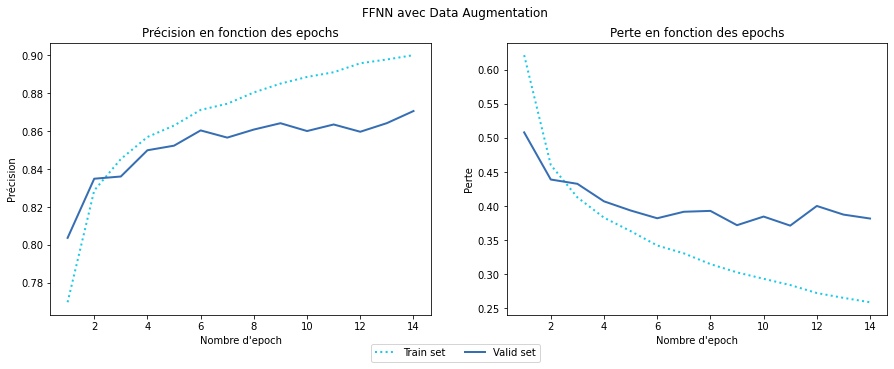

In [66]:
model, epoch, accuracy, val_accuracy, loss, val_loss \
    = create_train_save_load(X_train_augmented, y_train_augmented, 
                             X_valid_augmented, y_valid_augmented, 
                             name="ffnn_data_augmented",func=create_and_fit_FFNN, 
                             early_stop=True)

plot_acc_loss(epoch, accuracy, val_accuracy , loss, val_loss , 
              title='FFNN avec Data Augmentation', training=True)


+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~ Perte sur le jeu de test : ~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

0.3542

+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~ Précision sur le jeu de test : ~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

0.8788

+---------------------------------------------------------------------------+
¦~~~~~~~~~~ Matrice de confusion et métriques de classification : ~~~~~~~~~~¦
+---------------------------------------------------------------------------+



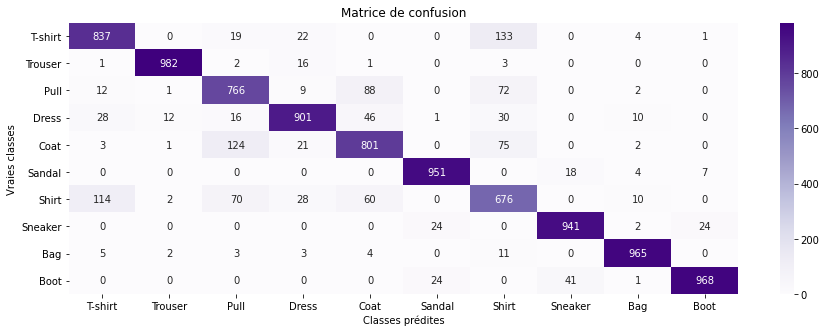

,T-shirt,Trouser,Pull,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Boot
precision,0.823819,0.977114,0.806316,0.863027,0.779942,0.970408,0.704167,0.949546,0.971803,0.936170
recall,0.837000,0.982000,0.766000,0.901000,0.801000,0.951000,0.676000,0.941000,0.965000,0.968000
f1-score,0.830357,0.979551,0.785641,0.881605,0.790331,0.960606,0.689796,0.945254,0.968389,0.951819


In [67]:
y_pred = model.predict(X_test)
df = append_evaluation(df,model,X_test,y_test,y_pred)
show_evaluation(model,X_test,y_test,y_pred)

In [68]:
compare_models(df)

,Model,Accuracy,Loss
0,DefaultCNN_cnn,0.922100,0.268270
1,DefaultCNN_early_stop_cnn,0.913600,0.239828
2,DefaultCNN_tuned,0.919200,0.228566
3,DefaultCNN_data_augmented,0.921000,0.218162
4,FFNN_ffnn,0.877200,0.347898
5,FFNN_ffnn_data_augmented,0.878800,0.354178


<div class='alert alert-info' role='alert'><p>
    
Ce modèle est clairement moins performant que le modèle CNN par défaut. Malgré tout, il obtient de plutôt bons scores (environ *87%* de précision). Avec cette architecture, les prédictions concernant les chemises (*Shirt*) sont également celles qui posent le plus de difficultés.
    
</p></div>

## CNN avec AveragePooling

Le deuxième architecture que nous allons créer est celle d'un réseau de neurone convolutif inspiré du modèle par défaut. Cette fois-ci, on ne va pas utiliser des couches de Max Pooling. À la place, nous allons utiliser des couches d'Average Pooling.

> - Couche de **convolution** à $64$ filtres de forme $5 \times 5$ et activation 'ReLU'
> - Couche de **Average Pooling** de forme $2 \times 2$
> - Couche de **Dropout** avec probabilité $0.25$
>
> - Couche de **convolution** à $128$ filtres de forme $5 \times 5$ et activation 'ReLU'
> - Couche de **Average Pooling** de forme $2 \times 2$
> - Couche de **Dropout** avec probabilité $0.25$
>
> - Couche de **convolution** à $256$ filtres de forme $3 \times 3$ et activation 'ReLU'
> - Couche de **Average Pooling** de forme $2 \times 2$
> - Couche de **Dropout** avec probabilité $0.25$
>
> - Couche **dense** à $256$ neurones
> - Couche de **Dropout** avec probabilité $0.5$
> - Couche de perte avec activation **softmax**


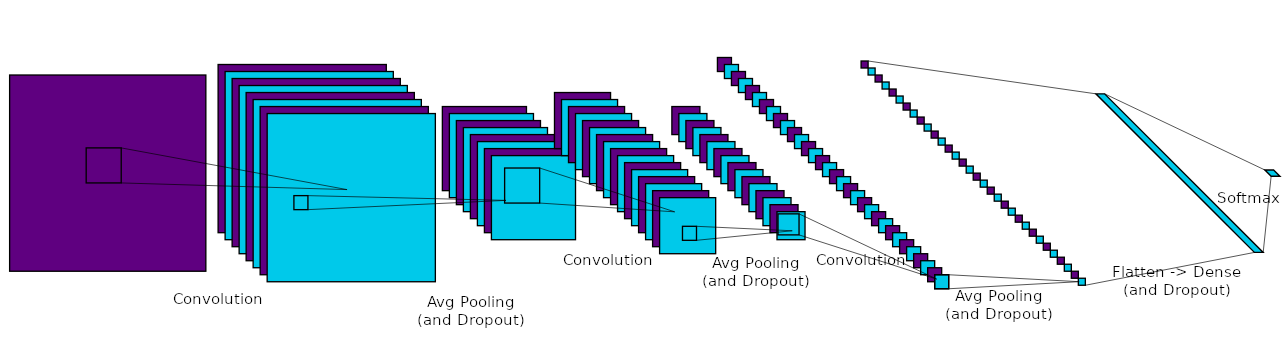

In [69]:
def create_avg_pool_CNN(name="") :
    """
    
    Create a CNN model with average pooling
    
    Parameters
    ----------
    name :
        name of the model
  
    Returns
    ----------
    model_cnn
    
    """
    # Fix randomness for reproducibility
    tf.random.set_seed(75) 
    seed(75)
    input_shape = INPUT_SHAPE
    model_cnn = Sequential(name="AvgPoolCNN_"+name)
    model_cnn.add(Conv2D(64, kernel_size=(5,5), activation='relu', 
                         input_shape=input_shape, name='Convolu_1'))
    model_cnn.add(AveragePooling2D(pool_size=(2,2), name='AvgPool_1'))
    model_cnn.add(Dropout(.25, name='Dropout_1'))
    model_cnn.add(Conv2D(128, kernel_size=(5,5), activation='relu', name='Convolu_2'))
    model_cnn.add(AveragePooling2D(pool_size=(2,2), name='AvgPool_2'))
    model_cnn.add(Dropout(.25, name='Dropout_2'))
    model_cnn.add(Conv2D(256, kernel_size=(3,3), activation='relu', name='Convolu_3'))
    model_cnn.add(AveragePooling2D(pool_size=(2,2), name='AvgPool_3'))
    model_cnn.add(Dropout(.25, name='Dropout_3'))
    model_cnn.add(Flatten(name='Flatten_1')) # On doit donner un vecteur 1D à la couche dense
    model_cnn.add(Dense(256, activation='relu', name='Densely_1'))
    model_cnn.add(Dropout(.5, name='Dropout_4'))
    model_cnn.add(Dense(NB_CLASSES, activation='softmax', name='Softmax'))  
    model_cnn.compile(loss=losses.categorical_crossentropy,
                    optimizer=optimizers.Adam(),
                    metrics=['accuracy'])
    return model_cnn


def create_and_fit_avg_pool_CNN(X_train,y_train,X_valid, y_valid,
                                epochs=100,
                                name="",
                                early_stop=True) :
    """
    Create a CNN model with average pooling and fit the model
    
    Parameters
    ----------
    X_train, y_train, X_valid, y_valid :
        train and valid datas
    epochs : 
        number of epochs
    name :
        name of the model
    early_stop :
        if True, do early stopping
    
    Returns
    ----------
    model, epochs, accuracy, val_accuracy, loss and val_loss
    
    """
    print_title("Entrainement du réseau neuronal "+name)
    model_cnn = create_avg_pool_CNN(name=name)
    return fit_NN(model_cnn, X_train, y_train,X_valid, y_valid,
                  epochs=epochs,verbose=1, early_stop=early_stop)

print_params(create_avg_pool_CNN())


+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~~~ Architecture détaillée ~~~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

Model: "AvgPoolCNN_"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Convolu_1 (Conv2D)           (None, 24, 24, 64)        1664      
_________________________________________________________________
AvgPool_1 (AveragePooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
Dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
Convolu_2 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
AvgPool_2 (AveragePooling2D) (None, 4, 4, 128)         0         
_________________

### Entraînement sur les données initiales

On va entraîner de modèle sur les données de base (sans *Data augmentation*) puis on affiche les scores obtenus.

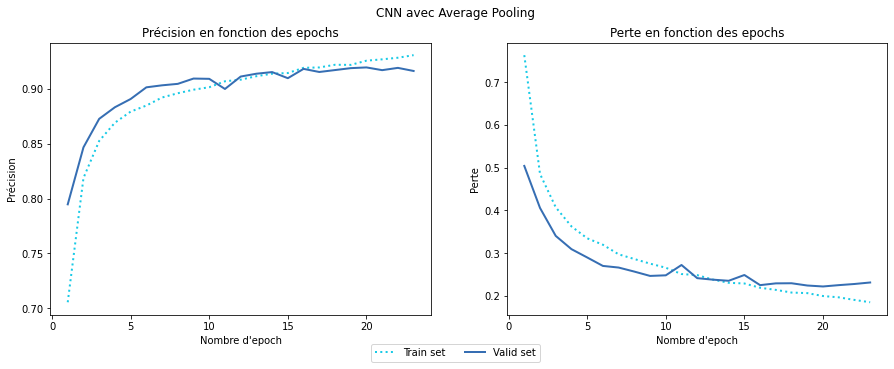

In [70]:
model, epoch, accuracy, val_accuracy, loss, val_loss \
    = create_train_save_load(X_train, y_train, X_valid, y_valid, 
                             name="cnn_avg_pool",func=create_and_fit_avg_pool_CNN, 
                             early_stop=True)

plot_acc_loss(epoch, accuracy, val_accuracy , loss, val_loss , 
              title='CNN avec Average Pooling', training=True)


+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~ Perte sur le jeu de test : ~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

0.2497

+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~ Précision sur le jeu de test : ~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

0.9117

+---------------------------------------------------------------------------+
¦~~~~~~~~~~ Matrice de confusion et métriques de classification : ~~~~~~~~~~¦
+---------------------------------------------------------------------------+



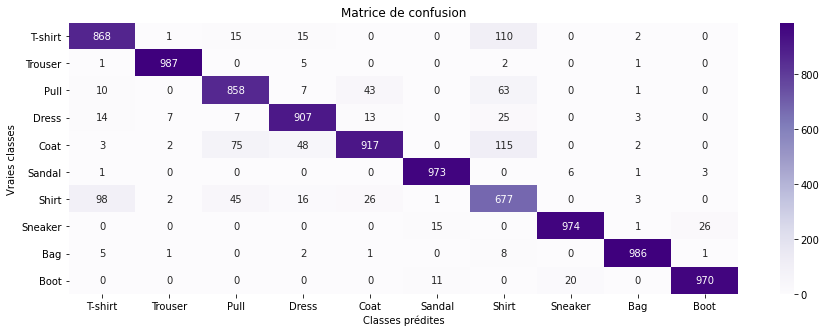

,T-shirt,Trouser,Pull,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Boot
precision,0.858556,0.990964,0.873727,0.929303,0.789157,0.988821,0.779954,0.958661,0.982072,0.969031
recall,0.868000,0.987000,0.858000,0.907000,0.917000,0.973000,0.677000,0.974000,0.986000,0.970000
f1-score,0.863252,0.988978,0.865792,0.918016,0.848289,0.980847,0.724839,0.966270,0.984032,0.969515


In [71]:
y_pred = model.predict(X_test)
df = append_evaluation(df,model,X_test,y_test,y_pred)
show_evaluation(model,X_test,y_test,y_pred)

In [72]:
compare_models(df)

,Model,Accuracy,Loss
0,DefaultCNN_cnn,0.922100,0.268270
1,DefaultCNN_early_stop_cnn,0.913600,0.239828
2,DefaultCNN_tuned,0.919200,0.228566
3,DefaultCNN_data_augmented,0.921000,0.218162
4,FFNN_ffnn,0.877200,0.347898
5,FFNN_ffnn_data_augmented,0.878800,0.354178
6,AvgPoolCNN_cnn_avg_pool,0.911700,0.249664


### Entraînement sur les données augmentées

On fait de même avec les données augmentées.

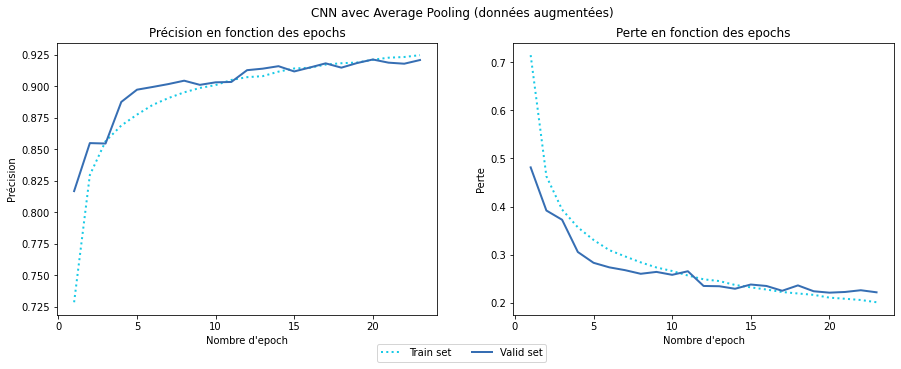

In [73]:
model, epoch, accuracy, val_accuracy, loss, val_loss \
    = create_train_save_load(X_train_augmented, y_train_augmented, 
                             X_valid_augmented, y_valid_augmented, 
                             name="cnn_avg_pool_data_augmented",func=create_and_fit_avg_pool_CNN, 
                             early_stop=True)

plot_acc_loss(epoch, accuracy, val_accuracy , loss, val_loss , 
              title='CNN avec Average Pooling (données augmentées)', training=True)


+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~ Perte sur le jeu de test : ~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

0.2282

+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~ Précision sur le jeu de test : ~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

0.9226

+---------------------------------------------------------------------------+
¦~~~~~~~~~~ Matrice de confusion et métriques de classification : ~~~~~~~~~~¦
+---------------------------------------------------------------------------+



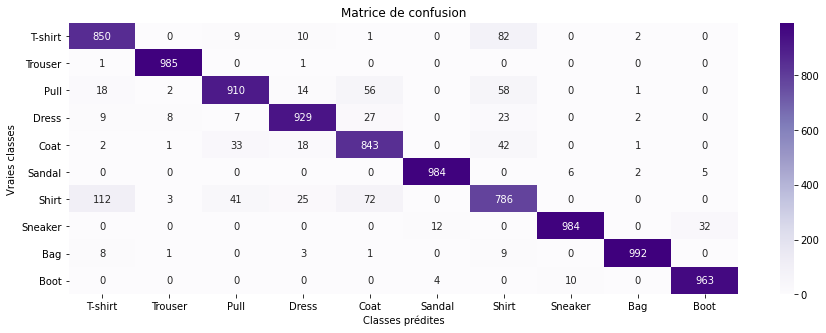

,T-shirt,Trouser,Pull,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Boot
precision,0.890985,0.997974,0.859301,0.924378,0.896809,0.986961,0.756497,0.957198,0.978304,0.985670
recall,0.850000,0.985000,0.910000,0.929000,0.843000,0.984000,0.786000,0.984000,0.992000,0.963000
f1-score,0.870010,0.991444,0.883924,0.926683,0.869072,0.985478,0.770966,0.970414,0.985104,0.974203


In [74]:
y_pred = model.predict(X_test)
df = append_evaluation(df,model,X_test,y_test,y_pred)
show_evaluation(model,X_test,y_test,y_pred)

In [75]:
compare_models(df)

,Model,Accuracy,Loss
0,DefaultCNN_cnn,0.922100,0.268270
1,DefaultCNN_early_stop_cnn,0.913600,0.239828
2,DefaultCNN_tuned,0.919200,0.228566
3,DefaultCNN_data_augmented,0.921000,0.218162
4,FFNN_ffnn,0.877200,0.347898
5,FFNN_ffnn_data_augmented,0.878800,0.354178
6,AvgPoolCNN_cnn_avg_pool,0.911700,0.249664
7,AvgPoolCNN_cnn_avg_pool_data_augmented,0.922600,0.228152


<div class='alert alert-info' role='alert'><p>
    
Ce modèle est aussi performant que le modèle CNN par défaut. On note qu'avec les données augmentées on obtient une meilleure précision et une meilleure perte que sur le modèle CNN par défaut. Mais ces différences restent très minimes. De même, avec cette architecture, les prédictions concernant les chemises (*Shirt*) sont également celles qui posent le plus de difficultés.
    
</p></div>

## CNN plus profond

La dernière architecture que nous allons créer est celle d'une réseau neuronal convolutif plus profond que le modèle par défaut. On va ajouter de nombreuses couches de convolutions. L'architecture est la suivante :


> - Couche de **convolution** à $64$ filtres de forme $3 \times 3$ et activation 'ReLU'
> - Couche de **convolution** à $64$ filtres de forme $3 \times 3$ et activation 'ReLU'
> - Couche de **convolution** à $128$ filtres de forme $5 \times 5$ et activation 'ReLU'
> - Couche de **convolution** à $64$ filtres de forme $3 \times 3$ et activation 'ReLU'
> - Couche de **Max Pooling** de forme $2 \times 2$
> - Couche de **Dropout** avec probabilité $0.25$
>
> - Couche de **convolution** à $256$ filtres de forme $5 \times 5$ et activation 'ReLU'
> - Couche de **convolution** à $64$ filtres de forme $3 \times 3$ et activation 'ReLU'
> - Couche de **Max Pooling** de forme $2 \times 2$
> - Couche de **Dropout** avec probabilité $0.25$
>
> - Couche **dense** à $512$ neurones
> - Couche de **Dropout** avec probabilité $0.5$
> - Couche de perte avec activation **softmax**

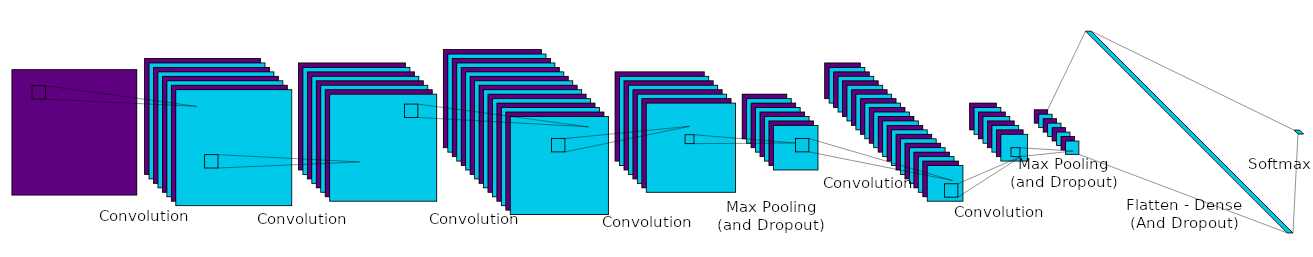

In [76]:
def create_DeeperCNN(name="") :
    """
    
    Create a Deeper CNN model 
    
    Parameters
    ----------
    name :
        name of the model
  
    Returns
    ----------
    model_cnn
    
    """
    # Fixer l'aléatoire pour la reproductibilité
    tf.random.set_seed(75) 
    seed(75)
    input_shape = INPUT_SHAPE
    model_cnn = Sequential(name="DeeperCNN_"+name)
    model_cnn.add(Conv2D(filters=64, 
                         kernel_size=(3, 3), 
                         activation='relu', 
                         input_shape=input_shape, 
                         name='Convolu_1'))
    model_cnn.add(Conv2D(filters=64, 
                         kernel_size=(3, 3), 
                         activation='relu', 
                         input_shape=input_shape, 
                         name='Convolu_1bis'))
    model_cnn.add(Conv2D(filters=128, 
                         kernel_size=(3, 3), 
                         activation='relu',
                         name='Convolu_2'))
    model_cnn.add(Conv2D(filters=64, 
                         kernel_size=(3, 3), 
                         activation='relu', 
                         input_shape=input_shape, 
                         name='Convolu_2bis'))
    model_cnn.add(MaxPooling2D(pool_size=(2,2), 
                               name='MaxPool_2'))
    model_cnn.add(Dropout(rate=0.25, 
                          name='Dropout_2'))
    model_cnn.add(Conv2D(filters=256, 
                         kernel_size=(3, 3), 
                         activation='relu',
                         name='Convolu_3'))
    model_cnn.add(Conv2D(filters=64, 
                         kernel_size=(3, 3), 
                         activation='relu', 
                         input_shape=input_shape, 
                         name='Convolu_3bis'))
    model_cnn.add(MaxPooling2D(pool_size=(2,2), 
                               name='MaxPool_3'))
    model_cnn.add(Dropout(rate=0.25, 
                          name='Dropout_3'))
    model_cnn.add(Flatten(name='Flatten_4'))
    model_cnn.add(Dense(units=512, activation='relu', name='Densely_4'))
    model_cnn.add(Dropout(rate=0.5, 
                          name='Dropout_4'))
    model_cnn.add(Dense(units=10, activation = 'softmax'))  
    model_cnn.compile(loss=losses.categorical_crossentropy,
                    optimizer=optimizers.Adam(),
                    metrics=['accuracy'])
    return model_cnn


def create_and_fit_DeeperCNN(X_train,y_train,X_valid, y_valid,
                             epochs=100,name="", early_stop=True) :
    """
    Create a deeper CNN model and fit the model
    
    Parameters
    ----------
    X_train, y_train, X_valid, y_valid :
        train and valid datas
    epochs : 
        number of epochs
    name :
        name of the model
    early_stop :
        if True, do early stopping
    
    Returns
    ----------
    model, epochs, accuracy, val_accuracy, loss and val_loss

    """
    print_title("Entrainement du réseau neuronal "+name)
    model_cnn = create_DeeperCNN(name=name)
    return fit_NN(model_cnn,X_train, y_train,X_valid, y_valid,
                epochs=epochs,verbose=1, early_stop=early_stop)

print_params(create_DeeperCNN())


+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~~~ Architecture détaillée ~~~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

Model: "DeeperCNN_"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Convolu_1 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
Convolu_1bis (Conv2D)        (None, 24, 24, 64)        36928     
_________________________________________________________________
Convolu_2 (Conv2D)           (None, 22, 22, 128)       73856     
_________________________________________________________________
Convolu_2bis (Conv2D)        (None, 20, 20, 64)        73792     
_________________________________________________________________
MaxPool_2 (MaxPooling2D)     (None, 10, 10, 64)        0         
__________________

### Entraînement sur les données initiales

On va entraîner de modèle sur les données de base (sans *Data augmentation*) puis on affiche les scores obtenus.

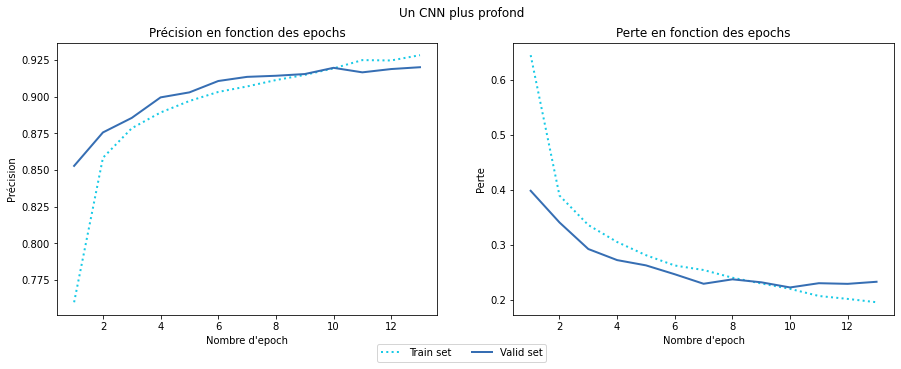

In [77]:
model, epoch, accuracy, val_accuracy, loss, val_loss \
    = create_train_save_load(X_train, y_train, 
                             X_valid, y_valid, 
                             name="deeper_cnn",func=create_and_fit_DeeperCNN, 
                             early_stop=True)

plot_acc_loss(epoch, accuracy, val_accuracy , loss, val_loss , 
              title='Un CNN plus profond', training=True)


+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~ Perte sur le jeu de test : ~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

0.2440

+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~ Précision sur le jeu de test : ~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

0.9150

+---------------------------------------------------------------------------+
¦~~~~~~~~~~ Matrice de confusion et métriques de classification : ~~~~~~~~~~¦
+---------------------------------------------------------------------------+



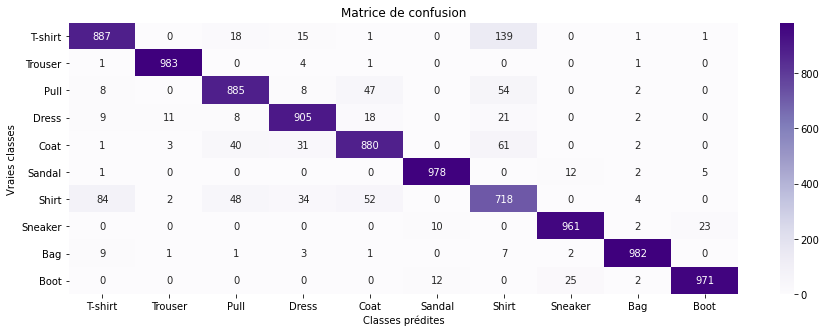

,T-shirt,Trouser,Pull,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Boot
precision,0.835217,0.992929,0.881474,0.929158,0.864440,0.979960,0.762208,0.964859,0.976143,0.961386
recall,0.887000,0.983000,0.885000,0.905000,0.880000,0.978000,0.718000,0.961000,0.982000,0.971000
f1-score,0.860330,0.987940,0.883234,0.916920,0.872151,0.978979,0.739444,0.962926,0.979063,0.966169


In [78]:
y_pred = model.predict(X_test)
df = append_evaluation(df,model,X_test,y_test,y_pred)
show_evaluation(model,X_test,y_test,y_pred)

In [79]:
compare_models(df)

,Model,Accuracy,Loss
0,DefaultCNN_cnn,0.922100,0.268270
1,DefaultCNN_early_stop_cnn,0.913600,0.239828
2,DefaultCNN_tuned,0.919200,0.228566
3,DefaultCNN_data_augmented,0.921000,0.218162
4,FFNN_ffnn,0.877200,0.347898
5,FFNN_ffnn_data_augmented,0.878800,0.354178
6,AvgPoolCNN_cnn_avg_pool,0.911700,0.249664
7,AvgPoolCNN_cnn_avg_pool_data_augmented,0.922600,0.228152
8,DeeperCNN_deeper_cnn,0.915000,0.244049


### Entraînement sur les données augmentées

On fait de même avec les données augmentées.

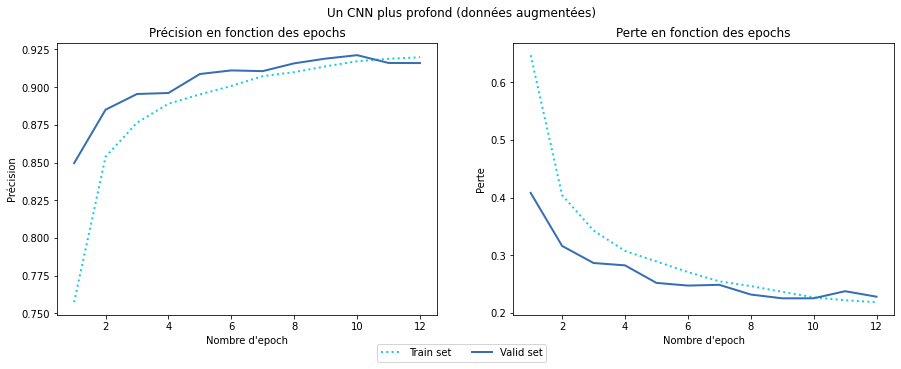

In [80]:
model, epoch, accuracy, val_accuracy, loss, val_loss \
    = create_train_save_load(X_train_augmented, y_train_augmented, 
                             X_valid_augmented, y_valid_augmented, 
                             name="deeper_cnn_data_augmented",func=create_and_fit_DeeperCNN, 
                             early_stop=True)

plot_acc_loss(epoch, accuracy, val_accuracy , loss, val_loss , 
              title='Un CNN plus profond (données augmentées)', training=True)


+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~ Perte sur le jeu de test : ~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

0.2314

+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~ Précision sur le jeu de test : ~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

0.9176

+---------------------------------------------------------------------------+
¦~~~~~~~~~~ Matrice de confusion et métriques de classification : ~~~~~~~~~~¦
+---------------------------------------------------------------------------+



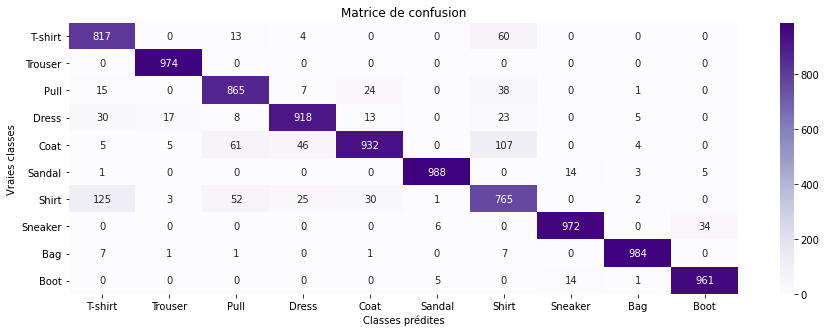

,T-shirt,Trouser,Pull,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Boot
precision,0.913870,1.000000,0.910526,0.905325,0.803448,0.977250,0.762712,0.960474,0.983017,0.979613
recall,0.817000,0.974000,0.865000,0.918000,0.932000,0.988000,0.765000,0.972000,0.984000,0.961000
f1-score,0.862724,0.986829,0.887179,0.911619,0.862963,0.982596,0.763854,0.966203,0.983508,0.970217


In [81]:
y_pred = model.predict(X_test)
df = append_evaluation(df,model,X_test,y_test,y_pred)
show_evaluation(model,X_test,y_test,y_pred)

In [82]:
compare_models(df)

,Model,Accuracy,Loss
0,DefaultCNN_cnn,0.922100,0.268270
1,DefaultCNN_early_stop_cnn,0.913600,0.239828
2,DefaultCNN_tuned,0.919200,0.228566
3,DefaultCNN_data_augmented,0.921000,0.218162
4,FFNN_ffnn,0.877200,0.347898
5,FFNN_ffnn_data_augmented,0.878800,0.354178
6,AvgPoolCNN_cnn_avg_pool,0.911700,0.249664
7,AvgPoolCNN_cnn_avg_pool_data_augmented,0.922600,0.228152
8,DeeperCNN_deeper_cnn,0.915000,0.244049
9,DeeperCNN_deeper_cnn_data_augmented,0.917600,0.231394



<div class='alert alert-info' role='alert'><p>
    
Ce modèle est aussi performant que le modèle CNN par défaut. Il obtient cependant une précision plus faible. Encore une fois, les différences sont très faibles. De même, avec cette architecture, les prédictions concernant les chemises (*Shirt*) sont également celles qui posent le plus de difficultés.
    
</p></div>

# Conclusion générale

On peut conclure que le modèle suggéré par l'énoncé est très bien paramétré. On obtient des scores très élevés sur le jeu de test :
- Précision de **92%**
- Perte de **0.26**

En modifiant les hyperparamètres des modèles, on peut obtenir quelques variations dans les scores de précision et de perte. Ces variations sont très faibles et ne permettent pas d'améliorer le modèle de manière significative. On peut même se demander si ces améliorations sont vraiment dues au paramétrage, ou bien si elles sont dues à l'aléa. 

En modifiant l'architecture ou en effectuant de l'augmentation des données (*Data augmentation*), on peut parfois mieux minimiser notre perte. 

Quelles que soient les modèles, on observe toujours des scores plus faibles quand il s'agit de chemises (*Shirt*), tant au niveau du score de précision que du score de rappel. Ainsi, le score F1 est globalement plus faible pour la classe des chemises. On pourrait expliquer cela naïvement par le fait que pour identifier une chemise, on a besoin d'observer certains détails de l'image (comme le col) alors que pour les autres classes de vêtement, observer leur forme permet de conclure.

Enfin, les architectures de type CNN semblent plus adaptées que les FFNN.

# Extension : prédictions à partir d'images quelconques

En guise d'extension, on peut se demander si le jeu de données `fashion_mnist` est représentatif de la réalité. On va essayer de prédire la classe de vêtement à partir d'images quelconque mais similaire. 

On va utiliser le modèle CNN par défaut suggéré en énoncé. 

In [83]:
def load_image(file) :
    """
    
    Load an image
    
    Parameters
    ----------
    file : 
        name of the file of the image
        
    Returns
    ----------
    the image
    
    """
    if (file.lower().endswith(('.png','jpg','jpeg'))) : 
        path = IMG_PATH +"/"+ file
        image = Image.open(path)
        return image
    
def convert_to_fashion_mnist_format(image) :
    """
    
    Convert an image in the same format as fashion_mnist
    
    Parameters
    ----------
    image : 
        the image
        
    Returns
    ----------
    the converted image
    
    """
    image = image.convert('L')
    image = image.resize( (28,28) )
    matrix = np.ones((28,28))*255
    image = matrix - image
    image = np.asarray(image)
    return image

def built_test(model) :
    """
    
    Test predictions from images 
    
    Parameters
    ----------
    model : 
        name of the model
        
    """
    for file in os.listdir(IMG_PATH):
        img = load_image(file)
        print_title("Image avant conversion")
        plt.imshow(img)
        plt.show()
        img = convert_to_fashion_mnist_format(img)
        img = img.reshape(1,28,28,1)
        y_pred = model.predict(img)
        show_prediction(y_pred, 0, X_test=[img])
        print(78*"_")


## Modèle par défaut sans données augmentées

On va tester le modèle par défaut, entraîné sans *Data Augmentation*.


+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~~~ Image avant conversion ~~~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+



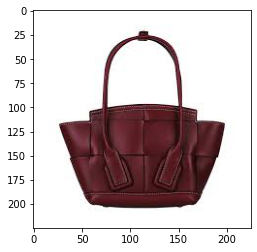


+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Image : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+



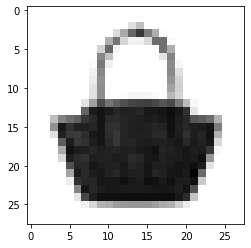


+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~~ Probabilité par classe : ~~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

T-shirt : 0.0000
Trouser : 0.0000
Pull : 0.0000
Dress : 0.0000
Coat : 0.0000
Sandal : 0.0000
Shirt : 0.0000
Sneaker : 0.0000
Bag : 1.0000
Boot : 0.0000

+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Prédiction :  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

BAG
______________________________________________________________________________

+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~~~ Image avant conversion ~~~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+



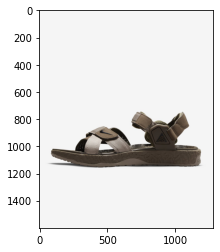


+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Image : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+



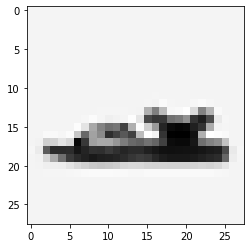


+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~~ Probabilité par classe : ~~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

T-shirt : 0.0000
Trouser : 0.0000
Pull : 0.0000
Dress : 0.0000
Coat : 0.0000
Sandal : 0.0000
Shirt : 0.0000
Sneaker : 0.0000
Bag : 1.0000
Boot : 0.0000

+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Prédiction :  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

BAG
______________________________________________________________________________

+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~~~ Image avant conversion ~~~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+



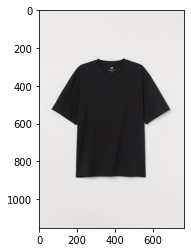


+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Image : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+



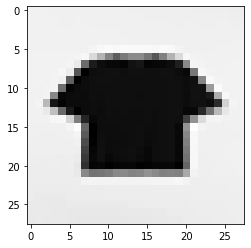


+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~~ Probabilité par classe : ~~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

T-shirt : 0.0000
Trouser : 0.0000
Pull : 0.0000
Dress : 0.0000
Coat : 0.0000
Sandal : 0.0000
Shirt : 1.0000
Sneaker : 0.0000
Bag : 0.0000
Boot : 0.0000

+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Prédiction :  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

SHIRT
______________________________________________________________________________

+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~~~ Image avant conversion ~~~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+



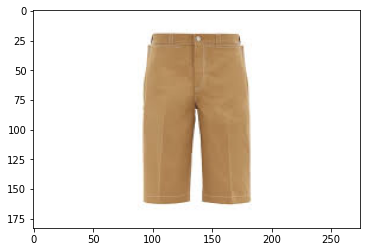


+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Image : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+



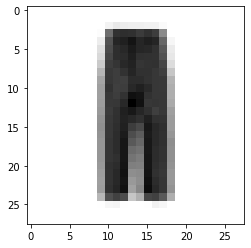


+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~~ Probabilité par classe : ~~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

T-shirt : 0.0000
Trouser : 1.0000
Pull : 0.0000
Dress : 0.0000
Coat : 0.0000
Sandal : 0.0000
Shirt : 0.0000
Sneaker : 0.0000
Bag : 0.0000
Boot : 0.0000

+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Prédiction :  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

TROUSER
______________________________________________________________________________


In [84]:
model = my_load_model_full("cnn")[0]
built_test(model)

## Modèle par défaut avec données augmentées

On va tester le modèle par défaut, entraîné avec les données augmentées (*Data Augmentation*).


+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~~~ Image avant conversion ~~~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+



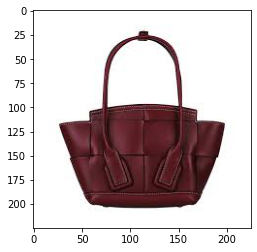


+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Image : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+



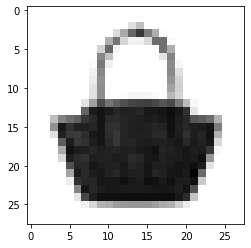


+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~~ Probabilité par classe : ~~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

T-shirt : 0.0000
Trouser : 0.0000
Pull : 0.0000
Dress : 0.0000
Coat : 0.0000
Sandal : 0.0000
Shirt : 0.0000
Sneaker : 0.0000
Bag : 1.0000
Boot : 0.0000

+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Prédiction :  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

BAG
______________________________________________________________________________

+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~~~ Image avant conversion ~~~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+



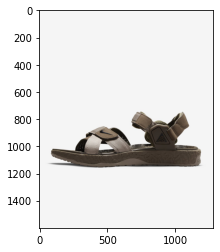


+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Image : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+



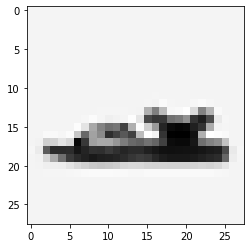


+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~~ Probabilité par classe : ~~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

T-shirt : 0.0000
Trouser : 0.0000
Pull : 0.0000
Dress : 0.0000
Coat : 0.0000
Sandal : 1.0000
Shirt : 0.0000
Sneaker : 0.0000
Bag : 0.0000
Boot : 0.0000

+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Prédiction :  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

SANDAL
______________________________________________________________________________

+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~~~ Image avant conversion ~~~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+



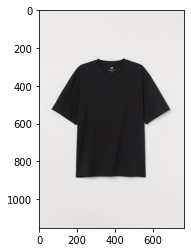


+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Image : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+



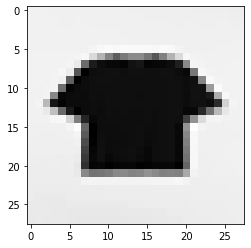


+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~~ Probabilité par classe : ~~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

T-shirt : 1.0000
Trouser : 0.0000
Pull : 0.0000
Dress : 0.0000
Coat : 0.0000
Sandal : 0.0000
Shirt : 0.0000
Sneaker : 0.0000
Bag : 0.0000
Boot : 0.0000

+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Prédiction :  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

T-SHIRT
______________________________________________________________________________

+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~~~ Image avant conversion ~~~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+



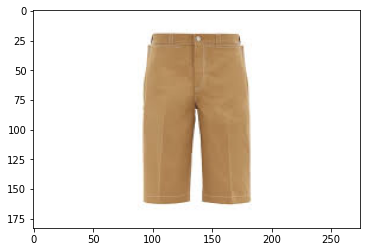


+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Image : ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+



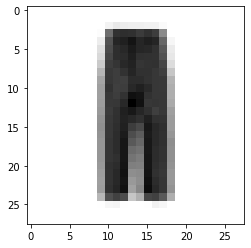


+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~~ Probabilité par classe : ~~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

T-shirt : 0.0000
Trouser : 1.0000
Pull : 0.0000
Dress : 0.0000
Coat : 0.0000
Sandal : 0.0000
Shirt : 0.0000
Sneaker : 0.0000
Bag : 0.0000
Boot : 0.0000

+---------------------------------------------------------------------------+
¦~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Prédiction :  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~¦
+---------------------------------------------------------------------------+

TROUSER
______________________________________________________________________________


In [85]:
model = my_load_model_full("data_augmented")[0]
built_test(model)

<div class='alert alert-info' role='alert'><p>
    
Dans ces exemples, peut voir que le modèle par défaut, sans *Data augmentation*, se trompe parfois. Alors que le modèle entraîné sur les données augmentées ne se trompe pas.
Ajouter du bruit aux images d'entraînement permet sans doute de mieux représenter les images bruitées que l'on peut trouver dans la réalité. 
    
</p></div>

<hr>

<div class="alert alert-warning" role="alert">

# Annexe : Énoncé du devoir

**Homework 1**

**A fashionable use case : clothing classification with `fashion-mnist`**

- Load data with `fashion_mnist.load_data()` 
- There is no validation set, only a train and test set. 
- The labels correspond to the following things

| Label number | Label name  |
|--------------|-------------|
| 0	           | T-shirt/top |
| 1	           | Trouser     |
| 2	           | Pullover    |
| 3	           | Dress       |
| 4	           | Coat        |
| 5	           | Sandal      |
| 6	           | Shirt       |
| 7	           | Sneaker     |
| 8	           | Bag         |
| 9	           | Ankle boot  |

**Your job**

- Try to understand the data, visualize it, like we did before with MNIST and noMNIST
- Create a neural network, using the ideas from before, that classify accurately the clothes on the test set
- You will need to build a validation set from the train set in order to tune hyperparameters

**We want to see the following things**

- Some learning curves (training) and the accuracy obtained on the test set for the architecture you considered
- A discussion about the impact of the hyperparameters on the accuracy (size of the kernels, number of kernels, number of layers, etc.) 
- A clear comparison between your solutions (a table, or plots comparing the results obtained with different hyper-parameters and different architectures)
- An explanation of what kind of clothes are hard to distinguish and why (some visual explanation)
- You'll get a good grade if you reach a good accuracy **and** if your notebook is clean, with clear graphs and explanations of what you did **and** if you did serious comparisons between different architectures
- You can do everything on your laptop, but it might be a good idea to use google `colab` (https://colab.research.google.com/) to get free access to a GPU
- You will send your notebook **containing** the results (**WE WON'T RUN YOUR NOTEBOOK**), namely with the graphs and results that you want to show, as a **unique** jupyter notebook file (`.ipynb` extension). We won't open any other supplementary file.

**Send your work using the following google form :**

- https://forms.gle/G3Rwfcuj3MZfgXhr8

(you will need to create a google account if you don't have one).

**Example of architecture**

As a start, you can use the following architecture (but you can and will change it) :

- Convolutional layer with 64 filters and 5 * 5 kernel sizes and 'relu' activation
- Max pooling with pool size 2 * 2
- Dropout with probability 0.25

- Convolutional layer with 128 filters and 5 * 5 kernel sizes and 'relu' activation
- Max pooling with pool size 2 * 2
- Dropout with probability 0.25

- Convolutional layer with 256 filters and 3 * 3 kernel sizes and 'relu' activation
- Max pooling with pool size 2 * 2
- Dropout with probability 0.25

- Dense layer with 256 units
- Dropout with probability 0.5
- Dense output layer with softmax activation
    

</div>
